## KGB Model LN Auto V2 - Asset Ownership

In [2]:
!pip install xgboost

  Using cached xgboost-2.0.3-py3-none-manylinux2014_x86_64.whl.metadata (2.0 kB)
Using cached xgboost-2.0.3-py3-none-manylinux2014_x86_64.whl (297.1 MB)

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import json
import logging
import xgboost as xgb
import ast
import itertools
import scipy.stats as ss
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import chi2
import os
import sys

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth', None)

In [4]:
sys.path.append('/root/Unified_LN_V2/')
from Utilities import *

In [4]:
Train = pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/2_LN_Auto_V2_Train_Funded_Data_250324.csv')
Test = pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/2_LN_Auto_V2_Test_Funded_Data_250324.csv')
Oot= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/2_LN_Auto_V2_Oot_Funded_Data_250324.csv')
TTD= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/2_LN_Auto_V2_TTD_Data_250324.csv')
# TTD_Oot= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/1_LN_Auto_V2_OOT_Data_220324.csv')

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((146855, 347), (62938, 347), (37121, 345), (700580, 345))

In [5]:
req_cols= ['assetpropevercount', 'sourcenonderogcount06month', 'addronfilecount', 'addrinputcountyratio', 'assetpropnewestsaleprice', 'addrcurrenttaxvalue', 'addrinputavmvalue', 'addrinputavmvalue60month', 'addrinputlastsaleprice', 'addrinputtaxmarketvalue', 'sourcecredheadertimeoldest', 'addrinputphonecount', 'assetpropcurrenttaxtotal', 'addrcurrentavmvalue', 'assetproppurchasetimeoldest', 'addrpreviouslengthofres', 'addrinputlengthofres', 'addrcurrenttaxmarketvalue', 'addrprevioustimenewest', 'addrcurrenttractratio', 'sourcenonderogcount12month', 'assetpropcurrentcount', 'addrinputsubjectcount', 'sourcenonderogcount', 'addrinputtaxvalue', 'assetpropeversoldcount', 'businessassociationtimeoldest', 'addrinputtractratio', 'derogtimenewest', 'addrchangecount24month', 'addrinputtimelastsale', 'educationinstitutionprivate', 'addrinputblockratio', 'businesstitleleadership', 'addrcurrentlengthofres', 'addrcurrentavmratio12monthprior', 'addrcurrentblockratio', 'derogcount', 'profliccount', 'addrinputavmratio60monthprior', 'addrcurrentcountyratio', 'assetpropsaletimeoldest', 'subjectrecordtimeoldest', 'addrcurrenttimenewest', 'proflictypecategory', 'criminalnonfelonytimenewest', 'lienjudgmentdollartotal', 'addrcurrentlastsalesprice', 'addrinputtimenewest', 'evictiontimenewest', 'bankruptcycount', 'addrcurrenttimelastsale', 'addrinputtimeoldest', 'addrlastmovetaxratiodiff', 'criminalnonfelonycount', 'sourcenonderogcount03month', 'addrchangecount03month', 'addrchangecount06month', 'addrchangecount12month', 'addrchangecount60month', 'addrcurrentavmratio60monthprior', 'addrcurrentavmvalue12month', 'addrcurrentavmvalue60month', 'addrcurrentcorrectional', 'addrcurrentdeedmailing', 'addrcurrentphoneservice', 'addrcurrentsubjectowned', 'addrcurrenttimeoldest', 'addrinputavmratio12monthprior', 'addrinputavmvalue12month', 'addrinputdeedmailing', 'addrinputphoneservice', 'addrinputproblems', 'addrinputsubjectowned', 'addrlastmoveecontrajectory', 'addronfilecollege', 'addronfilecorrectional', 'addronfilehighrisk', 'addrpreviouscorrectional', 'addrprevioussubjectowned', 'addrprevioustimeoldest', 'alertregulatorycondition', 'assetownership', 'assetpersonal', 'assetpersonalcount', 'assetprop', 'assetpropnewestmortgagetype', 'assetproppurchasecount12month', 'assetproppurchasetimenewest', 'assetpropsalepurchaseratio', 'assetpropsaletimenewest', 'assetpropsoldcount12month', 'bankruptcychapter', 'bankruptcycount24month', 'bankruptcydismissed24month', 'bankruptcystatus', 'bankruptcytimenewest', 'businessassociation', 'criminalfelonycount', 'criminalfelonycount12month', 'criminalfelonytimenewest', 'criminalnonfelonycount12month', 'derogcount12month', 'educationattendance', 'educationevidence', 'educationinstitutionrating', 'educationprogramattended', 'evictioncount', 'evictioncount12month', 'inquiryauto12month', 'inquirybanking12month', 'inquirycollections12month', 'inquirynonshortterm12month', 'inquiryshortterm12month', 'inquirytelcom12month', 'lienjudgmentcount', 'lienjudgmentcount12month', 'lienjudgmentcourtcount', 'lienjudgmentforeclosurecount', 'lienjudgmentothercount', 'lienjudgmentsmallclaimscount', 'lienjudgmenttaxcount', 'lienjudgmenttimenewest', 'shorttermloanrequest', 'shorttermloanrequest12month', 'shorttermloanrequest24month', 'sourcecredheadertimenewest', 'sourcevoterregistration', 'subjectnewestrecord12month', 'subjectrecordtimenewest']
len(req_cols)

130

In [6]:
all_cols= ['unique_id', 'client', 'app_date', 'approve_flag', 'funded_flag', 'fico_pb', 'fico_cb', 'bad_flag', 'product', 'auto_score', 'bankcard_score', 'Race', 'Gender', 'age_cuts'] + req_cols
len(all_cols)

144

In [7]:
print({'Length': Train['funded_flag'].sum(), 'Bads': Train['bad_flag'].sum()})
print({'Length': Test['funded_flag'].sum(), 'Bads': Test['bad_flag'].sum()})
print({'Length': Oot['funded_flag'].sum(), 'Bads': Oot['bad_flag'].sum()})

{'Length': 146855.0, 'Bads': 2227.0}
{'Length': 62938.0, 'Bads': 959.0}
{'Length': 37121.0, 'Bads': 545.0}


In [9]:
Train.shape, Test.shape, Oot.shape

((146855, 347), (62938, 347), (37121, 345))

In [10]:
print(TTD.shape)
TTD= TTD[TTD['client']!= 'CPM'].reset_index(drop= True)
print(TTD.shape)
# TTD_Oot= TTD_Oot[TTD_Oot['client']!= 'CPM'].reset_index(drop= True)

(700580, 345)
(685215, 345)


In [11]:
Train= Train[all_cols + ['weight']]
Test= Test[all_cols + ['weight']]
Oot= Oot[all_cols]
TTD= TTD[all_cols]
# TTD_Oot= TTD_Oot[all_cols]

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((146855, 145), (62938, 145), (37121, 144), (685215, 144))

In [12]:
Train.rename(columns= {'weight': 'wt2'}, inplace= True)
Test.rename(columns= {'weight': 'wt2'}, inplace= True)

In [13]:
Train['bad_flag'].mean(), Test['bad_flag'].mean(), Oot['bad_flag'].mean()

(0.015164618160770828, 0.015237217579204931, 0.01468171654858436)

In [14]:
TTD['funded_flag'].sum(), len(Train), len(Test)

(200148.0, 146855, 62938)

In [15]:
all_funded= pd.concat([Train, Test]).reset_index(drop= True)
all_funded.shape

(209793, 145)

In [16]:
all_funded['client'].value_counts(dropna= False)

client
Tower       42966
Arkansas    39869
GESA        28069
Guardian    27406
Numerica    25791
SECU        18365
Bethpage    11837
CPM          9645
HFCU         2895
Hawaii       2077
NCU           873
Name: count, dtype: int64

In [17]:
all_funded['bad_flag'].mean()

0.015186398020906322

In [18]:
def get_segment(d):
    if (d['derogcount']> 0):
        return 'Derog'
    elif ((d['derogcount']== 0) and (d['assetprop']> 0)):
        return 'Property Owner'
    elif ((d['derogcount']== 0) and (d['assetprop']== 0)):
        return 'Non Property Owner'
    else:
        return 'Missing'

In [19]:
%%time
all_funded['segment']= all_funded.apply(lambda x: get_segment(x), axis= 1)
all_funded['segment'].value_counts(dropna= False)

CPU times: user 4.84 s, sys: 2.9 ms, total: 4.85 s
Wall time: 5.93 s


segment
Property Owner        117191
Non Property Owner     69928
Derog                  22674
Name: count, dtype: int64

In [20]:
all_funded.groupby('segment')[['derogcount', 'assetprop']].agg(['min', 'max'])

derogcount       assetprop     
                          min   max       min  max
segment                                           
Derog                     1.0  52.0       0.0  1.0
Non Property Owner        0.0   0.0       0.0  0.0
Property Owner            0.0   0.0       1.0  1.0

In [21]:
%%time
TTD['segment']= TTD.apply(lambda x: get_segment(x), axis= 1)
TTD['segment'].value_counts(dropna= False)

CPU times: user 15 s, sys: 1.91 s, total: 16.9 s
Wall time: 18.8 s


segment
Property Owner        303020
Non Property Owner    275182
Derog                 107013
Name: count, dtype: int64

In [22]:
TTD.groupby('segment')[['derogcount', 'assetprop']].agg(['min', 'max'])

derogcount       assetprop     
                          min   max       min  max
segment                                           
Derog                     1.0  52.0       0.0  1.0
Non Property Owner        0.0   0.0       0.0  0.0
Property Owner            0.0   0.0       1.0  1.0

In [23]:
%%time
Oot['segment']= Oot.apply(lambda x: get_segment(x), axis= 1)
Oot['segment'].value_counts(dropna= False)

CPU times: user 880 ms, sys: 1.5 ms, total: 881 ms
Wall time: 1.1 s


segment
Property Owner        20750
Non Property Owner    12460
Derog                  3911
Name: count, dtype: int64

In [24]:
Oot.groupby('segment')[['derogcount', 'assetprop']].agg(['min', 'max'])

derogcount       assetprop     
                          min   max       min  max
segment                                           
Derog                     1.0  51.0       0.0  1.0
Non Property Owner        0.0   0.0       0.0  0.0
Property Owner            0.0   0.0       1.0  1.0

In [25]:
all_funded= all_funded[all_funded['segment']== 'Property Owner'].reset_index(drop= True)
TTD= TTD[TTD['segment']== 'Property Owner'].reset_index(drop= True)
Oot= Oot[Oot['segment']== 'Property Owner'].reset_index(drop= True)
print(all_funded.shape, all_funded['bad_flag'].mean()*100, all_funded['segment'].unique())
print(TTD.shape, TTD['segment'].unique())
print(Oot.shape, Oot['segment'].unique())
all_funded['client'].value_counts(dropna= False)

(117191, 146) 0.5845158757925096 ['Property Owner']
(303020, 145) ['Property Owner']
(20750, 145) ['Property Owner']


client
Tower       27637
Arkansas    26577
Numerica    13165
Guardian    12544
GESA        12540
SECU         9343
Bethpage     6721
CPM          5912
HFCU         1530
Hawaii        794
NCU           428
Name: count, dtype: int64

In [26]:
TTD['funded_flag'].sum(), len(Train), len(Test)

(111279.0, 146855, 62938)

In [27]:
all_funded['bad_flag'].mean()

0.005845158757925096

In [28]:
req_cols_orig= req_cols.copy()
len(req_cols_orig), len(req_cols)

(130, 130)

In [31]:
### Checking for the singular value variable 
var_singular= []
for v in req_cols:
    if all_funded[v].nunique()== 1:
        print(v, all_funded[v].unique())
        var_singular.append(v)
    else:
        continue
        
var_singular, len(var_singular)

derogtimenewest [-1.]
derogcount [0.]
criminalnonfelonytimenewest [-1.]
lienjudgmentdollartotal [0.]
evictiontimenewest [-1.]
bankruptcycount [0.]
criminalnonfelonycount [0.]
addrcurrentcorrectional [0.]
addrpreviouscorrectional [0.]
assetownership [1.]
assetprop [1.]
bankruptcychapter [0.]
bankruptcycount24month [0.]
bankruptcydismissed24month [0.]
bankruptcystatus [0.]
bankruptcytimenewest [-1.]
criminalfelonycount [0.]
criminalfelonycount12month [0.]
criminalfelonytimenewest [-1.]
criminalnonfelonycount12month [0.]
derogcount12month [0.]
evictioncount [0.]
evictioncount12month [0.]
lienjudgmentcount [0.]
lienjudgmentcount12month [0.]
lienjudgmentcourtcount [0.]
lienjudgmentforeclosurecount [0.]
lienjudgmentothercount [0.]
lienjudgmentsmallclaimscount [0.]
lienjudgmenttaxcount [0.]
lienjudgmenttimenewest [-1.]


(['derogtimenewest',
  'derogcount',
  'criminalnonfelonytimenewest',
  'lienjudgmentdollartotal',
  'evictiontimenewest',
  'bankruptcycount',
  'criminalnonfelonycount',
  'addrcurrentcorrectional',
  'addrpreviouscorrectional',
  'assetownership',
  'assetprop',
  'bankruptcychapter',
  'bankruptcycount24month',
  'bankruptcydismissed24month',
  'bankruptcystatus',
  'bankruptcytimenewest',
  'criminalfelonycount',
  'criminalfelonycount12month',
  'criminalfelonytimenewest',
  'criminalnonfelonycount12month',
  'derogcount12month',
  'evictioncount',
  'evictioncount12month',
  'lienjudgmentcount',
  'lienjudgmentcount12month',
  'lienjudgmentcourtcount',
  'lienjudgmentforeclosurecount',
  'lienjudgmentothercount',
  'lienjudgmentsmallclaimscount',
  'lienjudgmenttaxcount',
  'lienjudgmenttimenewest'],
 31)

In [33]:
req_cols= [col for col in req_cols_orig if col not in var_singular]
print(req_cols)
print(len(req_cols))

['assetpropevercount', 'sourcenonderogcount06month', 'addronfilecount', 'addrinputcountyratio', 'assetpropnewestsaleprice', 'addrcurrenttaxvalue', 'addrinputavmvalue', 'addrinputavmvalue60month', 'addrinputlastsaleprice', 'addrinputtaxmarketvalue', 'sourcecredheadertimeoldest', 'addrinputphonecount', 'assetpropcurrenttaxtotal', 'addrcurrentavmvalue', 'assetproppurchasetimeoldest', 'addrpreviouslengthofres', 'addrinputlengthofres', 'addrcurrenttaxmarketvalue', 'addrprevioustimenewest', 'addrcurrenttractratio', 'sourcenonderogcount12month', 'assetpropcurrentcount', 'addrinputsubjectcount', 'sourcenonderogcount', 'addrinputtaxvalue', 'assetpropeversoldcount', 'businessassociationtimeoldest', 'addrinputtractratio', 'addrchangecount24month', 'addrinputtimelastsale', 'educationinstitutionprivate', 'addrinputblockratio', 'businesstitleleadership', 'addrcurrentlengthofres', 'addrcurrentavmratio12monthprior', 'addrcurrentblockratio', 'profliccount', 'addrinputavmratio60monthprior', 'addrcurrent

In [43]:
# !mkdir /root/Unified_LN_V2/LN_Auto_V2/Model_Data/Property_Owner_Model
# !mkdir /root/Unified_LN_V2/LN_Auto_V2/Model_Data/Property_Owner_Model/Mono_Data
# !mkdir /root/Unified_LN_V2/LN_Auto_V2/Model_Data/Property_Owner_Model/Data

In [34]:
path_mono= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Property_Owner_Model/Mono_Data/'
path_data= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Property_Owner_Model/Data/'
path_model= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Property_Owner_Model/'

In [35]:
del Train, Test

In [36]:
## Splitting the data into train and test
from sklearn.model_selection import train_test_split
Train, Test= train_test_split(all_funded, test_size= 0.3, random_state= 2025)
print(Train.shape, Test.shape)
print(Train['bad_flag'].mean(), Test['bad_flag'].mean())
print(sum(Train['bad_flag']*Train['wt2'])/Train['wt2'].sum(), sum(Test['bad_flag']*Test['wt2'])/Test['wt2'].sum())

(82033, 146) (35158, 146)
0.0058513037436153745 0.005830820865805791
0.006873579050783077 0.00685989119415982


In [37]:
pref= 'Property_Owner'
Train.to_csv(f'{path_data}{pref}_Auto_train_raw_data_280324.csv', index= False)
Test.to_csv(f'{path_data}{pref}_Auto_test_raw_data_280324.csv', index= False)
Oot.to_csv(f'{path_data}{pref}_Auto_oot_raw_data_280324.csv', index= False)
TTD.to_csv(f'{path_data}{pref}_Auto_ttd_raw_data_280324.csv', index= False)

In [38]:
all_funded['fico_pb'].isnull().sum()

39

In [39]:
all_funded.groupby(['client']).agg(
    funded= ('funded_flag', 'sum'),
    bad= ('bad_flag', 'sum'),
    bad_rate= ('bad_flag', 'mean')
)

,funded,bad,bad_rate
client,,,
Arkansas,26577.0,93.0,0.003499
Bethpage,6721.0,26.0,0.003868
CPM,5912.0,37.0,0.006258
GESA,12540.0,81.0,0.006459
Guardian,12544.0,58.0,0.004624
HFCU,1530.0,17.0,0.011111
Hawaii,794.0,1.0,0.001259
NCU,428.0,2.0,0.004673
Numerica,13165.0,92.0,0.006988


In [40]:
del all_funded

In [41]:
Train['bad_flag'].mean(), Test['bad_flag'].mean(), Oot['bad_flag'].mean()

(0.0058513037436153745, 0.005830820865805791, 0.005397590361445783)

In [42]:
### Convert the Variable into categorical
var_to_cat= '''businesstitleleadership
proflictypecategory
addrcurrentdeedmailing
addrcurrentphoneservice
addrcurrentsubjectowned
addrinputdeedmailing
addrinputphoneservice
addrinputproblems
addrinputsubjectowned
addrlastmoveecontrajectory
addronfilecollege
addronfilecorrectional
addronfilehighrisk
addrprevioussubjectowned
alertregulatorycondition
assetownership
assetpersonal
assetprop
assetpropnewestmortgagetype
bankruptcychapter
bankruptcystatus
businessassociation
educationattendance
educationevidence
educationinstitutionrating
educationprogramattended
inquiryauto12month
inquirybanking12month
inquirycollections12month
inquirynonshortterm12month
inquiryshortterm12month
inquirytelcom12month
shorttermloanrequest
shorttermloanrequest12month
shorttermloanrequest24month
subjectnewestrecord12month
sourcevoterregistration'''.splitlines()
len(var_to_cat)

37

In [43]:
for var in var_to_cat:
    Train[var]= [f"[{i}]" if i!= '[-1]' else i for i in Train[var].astype(int).astype(str)]
    Test[var]= [f"[{i}]" if i!= '[-1]' else i for i in Test[var].astype(int).astype(str)]
    Oot[var]= [f"[{i}]" if i!= '[-1]' else i for i in Oot[var].astype(int).astype(str)]
    TTD[var]= [f"[{i}]" if i!= '[-1]' else i for i in TTD[var].astype(int).astype(str)]

In [44]:
print(Train['bankruptcystatus'].value_counts(dropna= False))
print(Test['bankruptcystatus'].value_counts(dropna= False))
print(Oot['bankruptcystatus'].value_counts(dropna= False))
print(TTD['bankruptcystatus'].value_counts(dropna= False))

bankruptcystatus
[0]    82033
Name: count, dtype: int64
bankruptcystatus
[0]    35158
Name: count, dtype: int64
bankruptcystatus
[0]    20750
Name: count, dtype: int64
bankruptcystatus
[0]    303020
Name: count, dtype: int64


#### Monotonic Binning

In [45]:
import pickle

configFile= Train[req_cols].dtypes.reset_index()
configFile.columns= ['Feature_Name', 'dtypes']
configFile['Special_values']= '[[-1]]'
# configFile['Monotonicity']= 'Y'
configFile['Monotonicity']= np.where(~configFile['Feature_Name'].isin(var_to_cat), 'Y', 'N')
del configFile['dtypes']
configFile.head()

,Feature_Name,Special_values,Monotonicity
0,assetpropevercount,[[-1]],Y
1,sourcenonderogcount06month,[[-1]],Y
2,addronfilecount,[[-1]],Y
3,addrinputcountyratio,[[-1]],Y
4,assetpropnewestsaleprice,[[-1]],Y


In [46]:
with open(f'{path_mono}configFile.pickle', 'wb') as f:
    pickle.dump(configFile, f)

In [47]:
dep_var = "bad_flag"
weight_column = 'wt2'
min_bin_size = 0.1
index_col=[]

In [48]:
# Get feature meta
# special_values = pd.read_csv(config_file)
import ast
special_values= configFile.copy()
# Converting the string entered in CSV to list of lists
special_values['Special_values'] = special_values['Special_values'].apply(lambda x: ast.literal_eval(str(x)))
# Generate feature meta
feature_meta = GenMeta(Train, index_col, sample_size=50000)
feature_meta = pd.merge(feature_meta, special_values, on="Feature_Name", how="left").replace(np.nan, '')
feature_meta.index = feature_meta['Feature_Name']
feature_meta.head()

,Feature_Name,Datatype,Special_values,Monotonicity
Feature_Name,,,,
unique_id,unique_id,string,,
client,client,string,,
app_date,app_date,string,,
approve_flag,approve_flag,float,,
funded_flag,funded_flag,float,,


In [49]:
with open(f'{path_mono}feature_meta.pickle', 'wb') as f:
    pickle.dump(feature_meta, f)

In [50]:
# Get numeric and embedding dataframe
embed_df, numeric_df = embedding_numeric_df(feature_meta, dep_var, index_col)

# Removing weight_column and columns that are not mentioned in the config file
embed_df.loc[np.invert(embed_df['Feature_Name'].isin(special_values['Feature_Name'].tolist())), 'Use_Feature'] = 'N'
numeric_df.loc[
        np.invert(numeric_df['Feature_Name'].isin(special_values['Feature_Name'].tolist())), 'Use_Feature'] = 'N'

if weight_column is not None:
    numeric_df.loc[numeric_df['Feature_Name'] == weight_column, 'Use_Feature'] = 'N'
    
display(numeric_df.head())
display(embed_df.head())

,Feature_Name,Use_Feature,Bucket_Size
Feature_Name,,,
approve_flag,approve_flag,N,10
funded_flag,funded_flag,N,10
fico_pb,fico_pb,N,10
fico_cb,fico_cb,N,10
bad_flag,bad_flag,N,10


,Feature_Name,Use_Feature,Num_Hash_Buckets,Num_Embedding_Columns
Feature_Name,,,,
unique_id,unique_id,N,10,2
client,client,N,10,2
app_date,app_date,N,10,2
product,product,N,10,2
Race,Race,N,10,2


In [51]:
with open(f'{path_mono}embed_df.pickle', 'wb') as f:
    pickle.dump(embed_df, f)

with open(f'{path_mono}numeric_df.pickle', 'wb') as f:
    pickle.dump(numeric_df, f)

In [52]:
# Get feature boundaries
feature_boundaries, numeric_df = get_boundaries_cart(filename=Train, sample_size=5000, shuffle_ind=False,
                                                         batch_size=100000,
                                                         shuffle_size=50000, feature_meta=feature_meta,
                                                         numeric_df=numeric_df,
                                                         dep_var=dep_var,
                                                         weight_column=weight_column, min_bin_size=float(min_bin_size))

assetpropevercount
1.0
assetpropevercount : [-inf, 2.0, 3.0, 4.0, inf]
sourcenonderogcount06month
0.0
sourcenonderogcount06month : [-inf, 2.0, 3.0, inf]
addronfilecount
0.0
addronfilecount : [-inf, 5.0, 8.0, inf]
addrinputcountyratio
0.0
addrinputcountyratio : [-inf, 0.560000002, 0.879999995, 1.01999998, 1.17999995, 1.38, inf]
assetpropnewestsaleprice
1.0
assetpropnewestsaleprice : [-inf, 74000.0, 113000.0, 324900.0, inf]
addrcurrenttaxvalue
0.0
addrcurrenttaxvalue : [-inf, 709.0, 191000.0, 314500.0, inf]
addrinputavmvalue
2367.0
addrinputavmvalue : [-inf, 98060.0, 171517.0, 208060.0, 285368.0, 349550.0, 486892.0, inf]
addrinputavmvalue60month
2898.0
addrinputavmvalue60month : [-inf, 80000.0, 124532.0, 180280.0, 275000.0, 402276.0, inf]
addrinputlastsaleprice
1.0
addrinputlastsaleprice : [-inf, 130000.0, 195000.0, 244000.0, 340500.0, inf]
addrinputtaxmarketvalue
0.0
addrinputtaxmarketvalue : [-inf, 89800.0, 165600.0, 339200.0, inf]
sourcecredheadertimeoldest
1.0
sourcecredheadertimeold

In [53]:
with open(f'{path_mono}feature_boundaries.pickle', 'wb') as f:
    pickle.dump(feature_boundaries, f)

In [54]:
# Get train bivar tables + get binned train dataframe
bivar_tables, rep_values, binned_df = get_bivar_tables(filename=Train, predicted=None,
                                                           feature_meta=feature_meta,
                                                           feature_boundaries=feature_boundaries,
                                                           num_features=numeric_df.loc[numeric_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                                           embed_features=embed_df.loc[embed_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                                           dep_var=dep_var, weight_column=None)

assetpropevercount
sourcenonderogcount06month
addronfilecount
addrinputcountyratio
assetpropnewestsaleprice
addrcurrenttaxvalue
addrinputavmvalue
addrinputavmvalue60month
addrinputlastsaleprice
addrinputtaxmarketvalue
sourcecredheadertimeoldest
addrinputphonecount
assetpropcurrenttaxtotal
addrcurrentavmvalue
assetproppurchasetimeoldest
addrpreviouslengthofres
addrinputlengthofres
addrcurrenttaxmarketvalue
addrprevioustimenewest
addrcurrenttractratio
sourcenonderogcount12month
assetpropcurrentcount
addrinputsubjectcount
sourcenonderogcount
addrinputtaxvalue
assetpropeversoldcount
businessassociationtimeoldest
addrinputtractratio
addrchangecount24month
addrinputtimelastsale
educationinstitutionprivate
addrinputblockratio
addrcurrentlengthofres
addrcurrentavmratio12monthprior
addrcurrentblockratio
profliccount
addrinputavmratio60monthprior
addrcurrentcountyratio
assetpropsaletimeoldest
subjectrecordtimeoldest
addrcurrenttimenewest
addrcurrentlastsalesprice
addrinputtimenewest
addrcurrentt

In [55]:
# Get train bivar tables + get binned train dataframe
bivar_tables_holdout, rep_values_holdout, binned_df_holdout = get_bivar_tables(filename=Test, predicted=None,
                                                           feature_meta=feature_meta,
                                                           feature_boundaries=feature_boundaries,
                                                           num_features=numeric_df.loc[numeric_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                                           embed_features=embed_df.loc[embed_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                                           dep_var=dep_var, weight_column=None)

assetpropevercount
sourcenonderogcount06month
addronfilecount
addrinputcountyratio
assetpropnewestsaleprice
addrcurrenttaxvalue
addrinputavmvalue
addrinputavmvalue60month
addrinputlastsaleprice
addrinputtaxmarketvalue
sourcecredheadertimeoldest
addrinputphonecount
assetpropcurrenttaxtotal
addrcurrentavmvalue
assetproppurchasetimeoldest
addrpreviouslengthofres
addrinputlengthofres
addrcurrenttaxmarketvalue
addrprevioustimenewest
addrcurrenttractratio
sourcenonderogcount12month
assetpropcurrentcount
addrinputsubjectcount
sourcenonderogcount
addrinputtaxvalue
assetpropeversoldcount
businessassociationtimeoldest
addrinputtractratio
addrchangecount24month
addrinputtimelastsale
educationinstitutionprivate
addrinputblockratio
addrcurrentlengthofres
addrcurrentavmratio12monthprior
addrcurrentblockratio
profliccount
addrinputavmratio60monthprior
addrcurrentcountyratio
assetpropsaletimeoldest
subjectrecordtimeoldest
addrcurrenttimenewest
addrcurrentlastsalesprice
addrinputtimenewest
addrcurrentt

In [56]:
# Get train bivar tables + get binned train dataframe
binned_df_oot = get_bivar_tables_test(filename=Oot, predicted=None,
                                   feature_meta=feature_meta,
                                   feature_boundaries=feature_boundaries,
                                   num_features=numeric_df.loc[numeric_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                   embed_features=embed_df.loc[embed_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                   dep_var=None, weight_column= None)

assetpropevercount
sourcenonderogcount06month
addronfilecount
addrinputcountyratio
assetpropnewestsaleprice
addrcurrenttaxvalue
addrinputavmvalue
addrinputavmvalue60month
addrinputlastsaleprice
addrinputtaxmarketvalue
sourcecredheadertimeoldest
addrinputphonecount
assetpropcurrenttaxtotal
addrcurrentavmvalue
assetproppurchasetimeoldest
addrpreviouslengthofres
addrinputlengthofres
addrcurrenttaxmarketvalue
addrprevioustimenewest
addrcurrenttractratio
sourcenonderogcount12month
assetpropcurrentcount
addrinputsubjectcount
sourcenonderogcount
addrinputtaxvalue
assetpropeversoldcount
businessassociationtimeoldest
addrinputtractratio
addrchangecount24month
addrinputtimelastsale
educationinstitutionprivate
addrinputblockratio
addrcurrentlengthofres
addrcurrentavmratio12monthprior
addrcurrentblockratio
profliccount
addrinputavmratio60monthprior
addrcurrentcountyratio
assetpropsaletimeoldest
subjectrecordtimeoldest
addrcurrenttimenewest
addrcurrentlastsalesprice
addrinputtimenewest
addrcurrentt

In [57]:
# Get train bivar tables + get binned train dataframe
binned_df_ttd = get_bivar_tables_test(filename=TTD, predicted=None,
                                   feature_meta=feature_meta,
                                   feature_boundaries=feature_boundaries,
                                   num_features=numeric_df.loc[numeric_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                   embed_features=embed_df.loc[embed_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                   dep_var=None, weight_column= None)

assetpropevercount
sourcenonderogcount06month
addronfilecount
addrinputcountyratio
assetpropnewestsaleprice
addrcurrenttaxvalue
addrinputavmvalue
addrinputavmvalue60month
addrinputlastsaleprice
addrinputtaxmarketvalue
sourcecredheadertimeoldest
addrinputphonecount
assetpropcurrenttaxtotal
addrcurrentavmvalue
assetproppurchasetimeoldest
addrpreviouslengthofres
addrinputlengthofres
addrcurrenttaxmarketvalue
addrprevioustimenewest
addrcurrenttractratio
sourcenonderogcount12month
assetpropcurrentcount
addrinputsubjectcount
sourcenonderogcount
addrinputtaxvalue
assetpropeversoldcount
businessassociationtimeoldest
addrinputtractratio
addrchangecount24month
addrinputtimelastsale
educationinstitutionprivate
addrinputblockratio
addrcurrentlengthofres
addrcurrentavmratio12monthprior
addrcurrentblockratio
profliccount
addrinputavmratio60monthprior
addrcurrentcountyratio
assetpropsaletimeoldest
subjectrecordtimeoldest
addrcurrenttimenewest
addrcurrentlastsalesprice
addrinputtimenewest
addrcurrentt

In [58]:
print(binned_df.shape, Train.shape)
print(binned_df_holdout.shape, Test.shape)
print(binned_df_oot.shape, Oot.shape)
print(binned_df_ttd.shape, TTD.shape)

(82033, 146) (82033, 146)
(35158, 146) (35158, 146)
(20750, 145) (20750, 145)
(303020, 145) (303020, 145)


In [59]:
binned_df.to_csv(f'{path_mono}{pref}_1_Auto_Train_Binned_Data_280324.csv', index= False)
binned_df_holdout.to_csv(f'{path_mono}{pref}_1_Auto_Test_Binned_Data_280324.csv', index= False)
binned_df_oot.to_csv(f'{path_mono}{pref}_1_Auto_Oot_Binned_Data_280324.csv', index= False)
binned_df_ttd.to_csv(f'{path_mono}{pref}_1_Auto_Ttd_Binned_Data_280324.csv', index= False)

In [60]:
del Train, Test, Oot, TTD, binned_df, binned_df_holdout, binned_df_oot, binned_df_ttd

#### Reading Data For Model Building

In [5]:
import gc
gc.collect()

0

In [6]:
pref= 'Property_Owner'
path_mono= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Property_Owner_Model/Mono_Data/'
path_data= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Property_Owner_Model/Data/'
path_model= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Property_Owner_Model/'

In [7]:
Train = pd.read_csv(f'{path_mono}{pref}_1_Auto_Train_Binned_Data_280324.csv')
Test = pd.read_csv(f'{path_mono}{pref}_1_Auto_Test_Binned_Data_280324.csv')
Oot= pd.read_csv(f'{path_mono}{pref}_1_Auto_Oot_Binned_Data_280324.csv')
TTD= pd.read_csv(f'{path_mono}{pref}_1_Auto_Ttd_Binned_Data_280324.csv')
# TTD_Oot= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/1_LN_Auto_V2_OOT_Data_220324.csv')

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((82033, 146), (35158, 146), (20750, 145), (303020, 145))

In [8]:
req_cols_orig= ['assetpropevercount', 'sourcenonderogcount06month', 'addronfilecount', 'addrinputcountyratio', 'assetpropnewestsaleprice', 'addrcurrenttaxvalue', 'addrinputavmvalue', 'addrinputavmvalue60month', 'addrinputlastsaleprice', 'addrinputtaxmarketvalue', 'sourcecredheadertimeoldest', 'addrinputphonecount', 'assetpropcurrenttaxtotal', 'addrcurrentavmvalue', 'assetproppurchasetimeoldest', 'addrpreviouslengthofres', 'addrinputlengthofres', 'addrcurrenttaxmarketvalue', 'addrprevioustimenewest', 'addrcurrenttractratio', 'sourcenonderogcount12month', 'assetpropcurrentcount', 'addrinputsubjectcount', 'sourcenonderogcount', 'addrinputtaxvalue', 'assetpropeversoldcount', 'businessassociationtimeoldest', 'addrinputtractratio', 'derogtimenewest', 'addrchangecount24month', 'addrinputtimelastsale', 'educationinstitutionprivate', 'addrinputblockratio', 'businesstitleleadership', 'addrcurrentlengthofres', 'addrcurrentavmratio12monthprior', 'addrcurrentblockratio', 'derogcount', 'profliccount', 'addrinputavmratio60monthprior', 'addrcurrentcountyratio', 'assetpropsaletimeoldest', 'subjectrecordtimeoldest', 'addrcurrenttimenewest', 'proflictypecategory', 'criminalnonfelonytimenewest', 'lienjudgmentdollartotal', 'addrcurrentlastsalesprice', 'addrinputtimenewest', 'evictiontimenewest', 'bankruptcycount', 'addrcurrenttimelastsale', 'addrinputtimeoldest', 'addrlastmovetaxratiodiff', 'criminalnonfelonycount', 'sourcenonderogcount03month', 'addrchangecount03month', 'addrchangecount06month', 'addrchangecount12month', 'addrchangecount60month', 'addrcurrentavmratio60monthprior', 'addrcurrentavmvalue12month', 'addrcurrentavmvalue60month', 'addrcurrentcorrectional', 'addrcurrentdeedmailing', 'addrcurrentphoneservice', 'addrcurrentsubjectowned', 'addrcurrenttimeoldest', 'addrinputavmratio12monthprior', 'addrinputavmvalue12month', 'addrinputdeedmailing', 'addrinputphoneservice', 'addrinputproblems', 'addrinputsubjectowned', 'addrlastmoveecontrajectory', 'addronfilecollege', 'addronfilecorrectional', 'addronfilehighrisk', 'addrpreviouscorrectional', 'addrprevioussubjectowned', 'addrprevioustimeoldest', 'alertregulatorycondition', 'assetownership', 'assetpersonal', 'assetpersonalcount', 'assetprop', 'assetpropnewestmortgagetype', 'assetproppurchasecount12month', 'assetproppurchasetimenewest', 'assetpropsalepurchaseratio', 'assetpropsaletimenewest', 'assetpropsoldcount12month', 'bankruptcychapter', 'bankruptcycount24month', 'bankruptcydismissed24month', 'bankruptcystatus', 'bankruptcytimenewest', 'businessassociation', 'criminalfelonycount', 'criminalfelonycount12month', 'criminalfelonytimenewest', 'criminalnonfelonycount12month', 'derogcount12month', 'educationattendance', 'educationevidence', 'educationinstitutionrating', 'educationprogramattended', 'evictioncount', 'evictioncount12month', 'inquiryauto12month', 'inquirybanking12month', 'inquirycollections12month', 'inquirynonshortterm12month', 'inquiryshortterm12month', 'inquirytelcom12month', 'lienjudgmentcount', 'lienjudgmentcount12month', 'lienjudgmentcourtcount', 'lienjudgmentforeclosurecount', 'lienjudgmentothercount', 'lienjudgmentsmallclaimscount', 'lienjudgmenttaxcount', 'lienjudgmenttimenewest', 'shorttermloanrequest', 'shorttermloanrequest12month', 'shorttermloanrequest24month', 'sourcecredheadertimenewest', 'sourcevoterregistration', 'subjectnewestrecord12month', 'subjectrecordtimenewest']
len(req_cols_orig)

130

In [9]:
req_cols= ['assetpropevercount', 'sourcenonderogcount06month', 'addronfilecount', 'addrinputcountyratio', 'assetpropnewestsaleprice', 'addrcurrenttaxvalue', 'addrinputavmvalue', 'addrinputavmvalue60month', 'addrinputlastsaleprice', 'addrinputtaxmarketvalue', 'sourcecredheadertimeoldest', 'addrinputphonecount', 'assetpropcurrenttaxtotal', 'addrcurrentavmvalue', 'assetproppurchasetimeoldest', 'addrpreviouslengthofres', 'addrinputlengthofres', 'addrcurrenttaxmarketvalue', 'addrprevioustimenewest', 'addrcurrenttractratio', 'sourcenonderogcount12month', 'assetpropcurrentcount', 'addrinputsubjectcount', 'sourcenonderogcount', 'addrinputtaxvalue', 'assetpropeversoldcount', 'businessassociationtimeoldest', 'addrinputtractratio', 'addrchangecount24month', 'addrinputtimelastsale', 'educationinstitutionprivate', 'addrinputblockratio', 'businesstitleleadership', 'addrcurrentlengthofres', 'addrcurrentavmratio12monthprior', 'addrcurrentblockratio', 'profliccount', 'addrinputavmratio60monthprior', 'addrcurrentcountyratio', 'assetpropsaletimeoldest', 'subjectrecordtimeoldest', 'addrcurrenttimenewest', 'proflictypecategory', 'addrcurrentlastsalesprice', 'addrinputtimenewest', 'addrcurrenttimelastsale', 'addrinputtimeoldest', 'addrlastmovetaxratiodiff', 'sourcenonderogcount03month', 'addrchangecount03month', 'addrchangecount06month', 'addrchangecount12month', 'addrchangecount60month', 'addrcurrentavmratio60monthprior', 'addrcurrentavmvalue12month', 'addrcurrentavmvalue60month', 'addrcurrentdeedmailing', 'addrcurrentphoneservice', 'addrcurrentsubjectowned', 'addrcurrenttimeoldest', 'addrinputavmratio12monthprior', 'addrinputavmvalue12month', 'addrinputdeedmailing', 'addrinputphoneservice', 'addrinputproblems', 'addrinputsubjectowned', 'addrlastmoveecontrajectory', 'addronfilecollege', 'addronfilecorrectional', 'addronfilehighrisk', 'addrprevioussubjectowned', 'addrprevioustimeoldest', 'alertregulatorycondition', 'assetpersonal', 'assetpersonalcount', 'assetpropnewestmortgagetype', 'assetproppurchasecount12month', 'assetproppurchasetimenewest', 'assetpropsalepurchaseratio', 'assetpropsaletimenewest', 'assetpropsoldcount12month', 'businessassociation', 'educationattendance', 'educationevidence', 'educationinstitutionrating', 'educationprogramattended', 'inquiryauto12month', 'inquirybanking12month', 'inquirycollections12month', 'inquirynonshortterm12month', 'inquiryshortterm12month', 'inquirytelcom12month', 'shorttermloanrequest', 'shorttermloanrequest12month', 'shorttermloanrequest24month', 'sourcecredheadertimenewest', 'sourcevoterregistration', 'subjectnewestrecord12month', 'subjectrecordtimenewest']
len(req_cols)

99

In [10]:
all_cols= ['unique_id', 'client', 'app_date', 'approve_flag', 'funded_flag', 'fico_pb', 'fico_cb', 'bad_flag', 'product', 'auto_score', 'bankcard_score', 'Race', 'Gender', 'age_cuts'] + req_cols_orig
len(all_cols)

144

In [11]:
Train[all_cols].head(2)

,unique_id,client,app_date,approve_flag,funded_flag,fico_pb,fico_cb,bad_flag,product,auto_score,bankcard_score,Race,Gender,age_cuts,assetpropevercount,sourcenonderogcount06month,addronfilecount,addrinputcountyratio,assetpropnewestsaleprice,addrcurrenttaxvalue,addrinputavmvalue,addrinputavmvalue60month,addrinputlastsaleprice,addrinputtaxmarketvalue,sourcecredheadertimeoldest,addrinputphonecount,assetpropcurrenttaxtotal,addrcurrentavmvalue,assetproppurchasetimeoldest,addrpreviouslengthofres,addrinputlengthofres,addrcurrenttaxmarketvalue,addrprevioustimenewest,addrcurrenttractratio,sourcenonderogcount12month,assetpropcurrentcount,addrinputsubjectcount,sourcenonderogcount,addrinputtaxvalue,assetpropeversoldcount,businessassociationtimeoldest,addrinputtractratio,derogtimenewest,addrchangecount24month,addrinputtimelastsale,educationinstitutionprivate,addrinputblockratio,businesstitleleadership,addrcurrentlengthofres,addrcurrentavmratio12monthprior,addrcurrentblockratio,derogcount,profliccount,addrinputavmratio60monthprior,addrcurrentcountyratio,assetpropsaletimeoldest,subjectrecordtimeoldest,addrcurrenttimenewest,proflictypecategory,criminalnonfelonytimenewest,lienjudgmentdollartotal,addrcurrentlastsalesprice,addrinputtimenewest,evictiontimenewest,bankruptcycount,addrcurrenttimelastsale,addrinputtimeoldest,addrlastmovetaxratiodiff,criminalnonfelonycount,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentavmratio60monthprior,addrcurrentavmvalue12month,addrcurrentavmvalue60month,addrcurrentcorrectional,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputavmratio12monthprior,addrinputavmvalue12month,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addrlastmoveecontrajectory,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrpreviouscorrectional,addrprevioussubjectowned,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonal,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsaletimenewest,assetpropsoldcount12month,bankruptcychapter,bankruptcycount24month,bankruptcydismissed24month,bankruptcystatus,bankruptcytimenewest,businessassociation,criminalfelonycount,criminalfelonycount12month,criminalfelonytimenewest,criminalnonfelonycount12month,derogcount12month,educationattendance,educationevidence,educationinstitutionrating,educationprogramattended,evictioncount,evictioncount12month,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,lienjudgmentcount,lienjudgmentcount12month,lienjudgmentcourtcount,lienjudgmentforeclosurecount,lienjudgmentothercount,lienjudgmentsmallclaimscount,lienjudgmenttaxcount,lienjudgmenttimenewest,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,sourcecredheadertimenewest,sourcevoterregistration,subjectnewestrecord12month,subjectrecordtimenewest
0,TCI256606,Numerica,2019-03-15,1.0,1.0,788.0,NaN,0.0,Auto,803.0,855.0,white,M,Age below 62,"[-inf, 2.0)","[2.0, 3.0)","[-inf, 5.0)","[1.18, 1.38)",[-1],"[191000.0, 314500.0)","[285368.0, 349550.0)","[180280.0, 275000.0)","[130000.0, 195000.0)","[165600.0, 339200.0)","[429.0, inf)","[0.364, inf)","[191900.0, 317790.0)","[285765.0, 343223.0)","[232.0, inf)","[46.0, 87.0)","[173.0, 305.0)","[191800.0, 338600.0)","[178.0, inf)","[0.71, 0.97)","[2.0, 3.0)","[-inf, 2.0)","[2.0, inf)","[3.0, 4.0)","[187000.0, 313400.0)","[-inf, 1.0)",[-1],"[0.86, 0.97)",-1.0,"[-inf, 1.0)","[163.0, inf)",[-1],"[0.82, 0.98)",[-1],"[240.0, inf)","[-inf, 1.3)","[0.9, 1.0)",0.0,"[-inf, 0.0588)","[-inf, 1.4)","[1.18, 1.4)",[-1],"[429.0, inf)","[-inf, 4.581)",[-1],-1.0,0.0,"[130000.0, 197000.0)","[-inf, 2.341)",-1.0,0.0,"[44.0, inf)","[174.0, 306.0)",[-1],0.0,"[2.0, 3.0)","[-inf, 0.0316)","[-inf, 0.06

In [12]:
print({'Length': Train['funded_flag'].sum(), 'Bads': Train['bad_flag'].sum(), 'Bad_Rate': Train['bad_flag'].mean()*100})
print({'Length': Test['funded_flag'].sum(), 'Bads': Test['bad_flag'].sum(), 'Bad_Rate': Test['bad_flag'].mean()*100})
print({'Length': Oot['funded_flag'].sum(), 'Bads': Oot['bad_flag'].sum(), 'Bad_Rate': Oot['bad_flag'].mean()*100})
print(Train['segment'].unique(), Test['segment'].unique(), Oot['segment'].unique(), TTD['segment'].unique())

{'Length': 82033.0, 'Bads': 480.0, 'Bad_Rate': 0.5851303743615375}
{'Length': 35158.0, 'Bads': 205.0, 'Bad_Rate': 0.5830820865805791}
{'Length': 20750.0, 'Bads': 112.0, 'Bad_Rate': 0.5397590361445783}
['Property Owner'] ['Property Owner'] ['Property Owner'] ['Property Owner']


In [13]:
Train.shape, Test.shape, Oot.shape

((82033, 146), (35158, 146), (20750, 145))

In [14]:
Train['wt2'].describe([0.9, 0.95, 0.99])

count    82033.000000
mean         1.381715
std          0.224243
min          1.060974
50%          1.334799
90%          1.626065
95%          1.776103
99%          2.196896
max          5.605634
Name: wt2, dtype: float64

In [15]:
Train.groupby('client')['wt2'].agg(['count', 'min', 'mean', 'max'])

,count,min,mean,max
client,,,,
Arkansas,18574,1.095290,1.431240,5.605634
Bethpage,4715,1.060974,1.253602,2.782988
CPM,4167,1.105308,1.399621,3.790274
GESA,8692,1.101697,1.402402,4.096512
Guardian,8790,1.121587,1.471660,4.692428
HFCU,1068,1.112439,1.381266,3.609243
Hawaii,561,1.084118,1.426887,2.444916
NCU,305,1.142343,1.458309,2.721442
Numerica,9150,1.096292,1.434652,4.509301


In [16]:
Train= Train[all_cols + ['wt2']]
Test= Test[all_cols + ['wt2']]
Oot= Oot[all_cols]
TTD= TTD[all_cols]
# TTD_Oot= TTD_Oot[all_cols]

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((82033, 145), (35158, 145), (20750, 144), (303020, 144))

In [17]:
### Convert the Variable into categorical
var_to_cat= '''businesstitleleadership
proflictypecategory
addrcurrentdeedmailing
addrcurrentphoneservice
addrcurrentsubjectowned
addrinputdeedmailing
addrinputphoneservice
addrinputproblems
addrinputsubjectowned
addrlastmoveecontrajectory
addronfilecollege
addronfilecorrectional
addronfilehighrisk
addrprevioussubjectowned
alertregulatorycondition
assetownership
assetpersonal
assetprop
assetpropnewestmortgagetype
bankruptcychapter
bankruptcystatus
businessassociation
educationattendance
educationevidence
educationinstitutionrating
educationprogramattended
inquiryauto12month
inquirybanking12month
inquirycollections12month
inquirynonshortterm12month
inquiryshortterm12month
inquirytelcom12month
shorttermloanrequest
shorttermloanrequest12month
shorttermloanrequest24month
subjectnewestrecord12month
sourcevoterregistration'''.splitlines()
len(var_to_cat)

37

In [18]:
var_to_cat= list(set(var_to_cat))
len(var_to_cat)

37

In [19]:
# for var in var_to_cat:
#     Train[var]= [f"[{i}]" if i!= '[-1]' else i for i in Train[var].astype(int).astype(str)]
#     Test[var]= [f"[{i}]" if i!= '[-1]' else i for i in Test[var].astype(int).astype(str)]
#     Oot[var]= [f"[{i}]" if i!= '[-1]' else i for i in Oot[var].astype(int).astype(str)]
#     TTD[var]= [f"[{i}]" if i!= '[-1]' else i for i in TTD[var].astype(int).astype(str)]

In [20]:
print(Train['bankruptcystatus'].value_counts(dropna= False))
print(Test['bankruptcystatus'].value_counts(dropna= False))
print(Oot['bankruptcystatus'].value_counts(dropna= False))
print(TTD['bankruptcystatus'].value_counts(dropna= False))

bankruptcystatus
[0]    82033
Name: count, dtype: int64
bankruptcystatus
[0]    35158
Name: count, dtype: int64
bankruptcystatus
[0]    20750
Name: count, dtype: int64
bankruptcystatus
[0]    303020
Name: count, dtype: int64


In [21]:
Train[req_cols].isnull().sum()

assetpropevercount                 0
sourcenonderogcount06month         0
addronfilecount                    0
addrinputcountyratio               0
assetpropnewestsaleprice           0
addrcurrenttaxvalue                0
addrinputavmvalue                  0
addrinputavmvalue60month           0
addrinputlastsaleprice             0
addrinputtaxmarketvalue            0
sourcecredheadertimeoldest         0
addrinputphonecount                0
assetpropcurrenttaxtotal           0
addrcurrentavmvalue                0
assetproppurchasetimeoldest        0
addrpreviouslengthofres            0
addrinputlengthofres               0
addrcurrenttaxmarketvalue          0
addrprevioustimenewest             0
addrcurrenttractratio              0
sourcenonderogcount12month         0
assetpropcurrentcount              0
addrinputsubjectcount              0
sourcenonderogcount                0
addrinputtaxvalue                  0
assetpropeversoldcount             0
businessassociationtimeoldest      0
a

In [22]:
path_to_save= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Property_Owner_Model/'

In [23]:
Train['funded_flag'].sum(), Train.shape, Train['bad_flag'].sum(), Train['bad_flag'].mean()

(82033.0, (82033, 145), 480.0, 0.0058513037436153745)

In [24]:
Test['funded_flag'].sum(), Test.shape, Test['bad_flag'].sum(), Test['bad_flag'].mean()

(35158.0, (35158, 145), 205.0, 0.005830820865805791)

In [25]:
def Bucket_Order(data):
    data['lower_bound'] = data['Bucket'].str.replace('[','').str.replace(']','').str.replace('(','').str.replace(')','').str.split(',').str[0]
    data['lower_bound'] = data['lower_bound'].apply(lambda x: -np.inf if x == '-inf' else np.inf if x == 'inf' else float(x))
    data = data.sort_values('lower_bound')
    a = data.loc[data['lower_bound']==-1]
    b = data.loc[data['lower_bound']!=-1]
    b['Is_Trend']= 'Yes' if (
            (b['Train_BadRate'].is_monotonic_decreasing and b['Test_BadRate'].is_monotonic_decreasing) or
            (b['Train_BadRate'].is_monotonic_increasing and b['Test_BadRate'].is_monotonic_increasing)
        ) else 'No'
    data = pd.concat(objs=[a,b])
    data = data.drop(columns=['lower_bound'])
    return data

In [26]:
# df_bv= pd.DataFrame()

# for col in req_cols:
#     print(col)
#     ### Train
#     temp_tr= Train.groupby(col).agg(
#         bad_count_tr= ('bad_flag', 'sum'),
#         bad_rate_tr= ('bad_flag', 'mean'),
#                                 # p1_bad_rate_tr= ('p1', 'mean'),
#                                    volume_tr= ('unique_id', 'count')).reset_index()
#     temp_tr.columns= ['Bucket', 'Train_BadCount', 'Train_BadRate', 'Train_Count']#'Train_P1', 
#     temp_tr.insert(0, 'variable', col)
    
#     # temp_tr= temp_tr.sort_values(by= ['bad_rate_tr']).reset_index(drop= True)
#     # temp_tr['bad_rate_rank_tr']= range(1, len(temp_tr)+1)
#     # temp_tr= temp_tr.sort_values(by= ['p1_bad_rate_tr']).reset_index(drop= True)
#     # temp_tr['p1_bad_rank_tr']= range(1, len(temp_tr)+1)
    
#     ### Test
#     temp_te= Test.groupby(col).agg(
#         bad_count_te= ('bad_flag', 'sum'),
#         bad_rate_te= ('bad_flag', 'mean'),
#                                 # p1_bad_rate_te= ('p1', 'mean'),
#                                   volume_te= ('unique_id', 'count')).reset_index()
#     temp_te.columns= ['Bucket', 'Test_BadCount', 'Test_BadRate', 'Test_Count']#'Test_P1', 
#     #temp_te['variable']= col
    
#     # temp_te= temp_te.sort_values(by= ['bad_rate_te']).reset_index(drop= True)
#     # temp_te['bad_rate_rank_te']= range(1, len(temp_te)+1)
#     # temp_te= temp_te.sort_values(by= ['p1_bad_rate_te']).reset_index(drop= True)
#     # temp_te['p1_bad_rank_te']= range(1, len(temp_te)+1)
    
#     ### Concatenating
#     temp= temp_tr.merge(temp_te, on= ['Bucket'], how= 'left')
#     # temp= temp.sort_values(by= ['bucket']).reset_index(drop= True)
#     temp= Bucket_Order(temp)
#     # display(temp)
    
#     df_bv= pd.concat([df_bv, temp]).reset_index(drop= True)
    
#     del temp, temp_tr, temp_te

In [27]:
pd.options.display.max_rows= 1000
# df_bv.head(10)

In [28]:
# var_trend_break= list(df_bv[(df_bv['Is_Trend']== 'No') & (~(df_bv['variable'].isin(var_to_cat)))]['variable'].unique())
# var_trend_break, len(var_trend_break)

In [29]:
var_trend_break= ['addronfilecount',
  'addrinputcountyratio',
  'addrcurrenttaxvalue',
  'addrinputavmvalue',
  'addrinputavmvalue60month',
  'addrinputlastsaleprice',
  'addrinputtaxmarketvalue',
  'sourcecredheadertimeoldest',
  'addrinputphonecount',
  'assetpropcurrenttaxtotal',
  'addrcurrentavmvalue',
  'addrpreviouslengthofres',
  'addrinputlengthofres',
  'addrcurrenttaxmarketvalue',
  'addrprevioustimenewest',
  'addrinputtaxvalue',
  'businessassociationtimeoldest',
  'addrinputtractratio',
  'addrinputtimelastsale',
  'educationinstitutionprivate',
  'addrinputblockratio',
  'addrcurrentlengthofres',
  'addrcurrentblockratio',
  'addrinputavmratio60monthprior',
  'assetpropsaletimeoldest',
  'subjectrecordtimeoldest',
  'addrcurrentlastsalesprice',
  'addrinputtimenewest',
  'addrinputtimeoldest',
  'addrcurrentavmratio60monthprior',
  'addrcurrentavmvalue12month',
  'addrcurrentavmvalue60month',
  'addrcurrenttimeoldest',
  'addrprevioustimeoldest',
  'assetproppurchasetimenewest',
  'assetpropsaletimenewest',
  'sourcecredheadertimenewest',
  'subjectrecordtimenewest']
len(var_trend_break), len(list(set(var_trend_break)))

(38, 38)

### Base Model Weighted Auto Without Segmentation Without FLA, LDA

In [30]:
!pip install hyperopt

  Using cached hyperopt-0.2.7-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached py4j-0.10.9.7-py2.py3-none-any.whl.metadata (1.5 kB)
Using cached hyperopt-0.2.7-py2.py3-none-any.whl (1.6 MB)
Using cached py4j-0.10.9.7-py2.py3-none-any.whl (200 kB)

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [31]:
import numpy as np
import pandas as pd
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
import h2o
from h2o.estimators import H2OXGBoostEstimator
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample
import warnings
warnings.filterwarnings('ignore')

In [32]:
### Starting H2o Session
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)
  Starting server from /opt/conda/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpqkn0h282
  JVM stdout: /tmp/tmpqkn0h282/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpqkn0h282/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,15 days
H2O_cluster_name:,H2O_from_python_unknownUser_k6wo7x
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.486 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [33]:
Train['unique_id']= Train['unique_id'].astype(str)
Test['unique_id']= Test['unique_id'].astype(str)
Oot['unique_id']= Oot['unique_id'].astype(str)
TTD['unique_id']= TTD['unique_id'].astype(str)

In [34]:
train_h2o = h2o.H2OFrame(Train)
test_h2o = h2o.H2OFrame(Test)
oot_h2o= h2o.H2OFrame(Oot)
ttd_h2o= h2o.H2OFrame(TTD)
print(Train.shape,train_h2o.shape,Test.shape,test_h2o.shape, oot_h2o.shape, ttd_h2o.shape)
bad_col = 'bad_flag'
Train[bad_col].mean(),Test[bad_col].mean()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
(82033, 145) (82033, 145) (35158, 145) (35158, 145) (20750, 144) (303020, 144)


(0.0058513037436153745, 0.005830820865805791)

In [35]:
# for col in var_to_cat:
#     train_h2o[col] = train_h2o[col].asfactor()
#     test_h2o[col] = test_h2o[col].asfactor()
#     oot_h2o[col] = oot_h2o[col].asfactor()
#     ttd_h2o[col] = ttd_h2o[col].asfactor()

In [36]:
for k in Train['bankruptcychapter'].unique():
    print(k, train_h2o[train_h2o['bankruptcychapter']== k].shape)

[0] (82033, 145)


In [37]:
train_h2o[req_cols].head(rows= 2)

assetpropevercount,sourcenonderogcount06month,addronfilecount,addrinputcountyratio,assetpropnewestsaleprice,addrcurrenttaxvalue,addrinputavmvalue,addrinputavmvalue60month,addrinputlastsaleprice,addrinputtaxmarketvalue,sourcecredheadertimeoldest,addrinputphonecount,assetpropcurrenttaxtotal,addrcurrentavmvalue,assetproppurchasetimeoldest,addrpreviouslengthofres,addrinputlengthofres,addrcurrenttaxmarketvalue,addrprevioustimenewest,addrcurrenttractratio,sourcenonderogcount12month,assetpropcurrentcount,addrinputsubjectcount,sourcenonderogcount,addrinputtaxvalue,assetpropeversoldcount,businessassociationtimeoldest,addrinputtractratio,addrchangecount24month,addrinputtimelastsale,educationinstitutionprivate,addrinputblockratio,businesstitleleadership,addrcurrentlengthofres,addrcurrentavmratio12monthprior,addrcurrentblockratio,profliccount,addrinputavmratio60monthprior,addrcurrentcountyratio,assetpropsaletimeoldest,subjectrecordtimeoldest,addrcurrenttimenewest,proflictypecategory,addrcurrentlastsalesprice,addrinputtimenewest,addrcurrenttimelastsale,addrinputtimeoldest,addrlastmovetaxratiodiff,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentavmratio60monthprior,addrcurrentavmvalue12month,addrcurrentavmvalue60month,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputavmratio12monthprior,addrinputavmvalue12month,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addrlastmoveecontrajectory,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrprevioussubjectowned,addrprevioustimeoldest,alertregulatorycondition,assetpersonal,assetpersonalcount,assetpropnewestmortgagetype,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsaletimenewest,assetpropsoldcount12month,businessassociation,educationattendance,educationevidence,educationinstitutionrating,educationprogramattended,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,sourcecredheadertimenewest,sourcevoterregistration,subjectnewestrecord12month,subjectrecordtimenewest
"[-inf, 2.0)","[2.0, 3.0)","[-inf, 5.0)","[1.18, 1.38)",[-1],"[191000.0, 314500.0)","[285368.0, 349550.0)","[180280.0, 275000.0)","[130000.0, 195000.0)","[165600.0, 339200.0)","[429.0, inf)","[0.364, inf)","[191900.0, 317790.0)","[285765.0, 343223.0)","[232.0, inf)","[46.0, 87.0)","[173.0, 305.0)","[191800.0, 338600.0)","[178.0, inf)","[0.71, 0.97)","[2.0, 3.0)","[-inf, 2.0)","[2.0, inf)","[3.0, 4.0)","[187000.0, 313400.0)","[-inf, 1.0)",[-1],"[0.86, 0.97)","[-inf, 1.0)","[163.0, inf)",[-1],"[0.82, 0.98)",[-1],"[240.0, inf)","[-inf, 1.3)","[0.9, 1.0)","[-inf, 0.0588)","[-inf, 1.4)","[1.18, 1.4)",[-1],"[429.0, inf)","[-inf, 4.581)",[-1],"[130000.0, 197000.0)","[-inf, 2.341)","[44.0, inf)","[174.0, 306.0)",[-1],"[2.0, 3.0)","[-inf, 0.0316)","[-inf, 0.0654)","[-inf, 1.0)","[-inf, 1.0)","[-inf, 1.4)","[259398.0, 346988.0)","[171996.0, 260775.0)",[0],[1],[1],"[241.0, inf)","[-inf, 1.3)","[259542.0, 345529.0)",[0],[1],[0],[1],[1],[0],[0],[0],[1],"[258.0, inf)",[1],[0],"[-inf, 1.0)",[0],"[-inf, 1.0)","[163.0, inf)","[-inf, 0.185)",[-1],"[-inf, 0.0357)",[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],"[-inf, 2.646)",[0],[1],"[-inf, 1.499)"
"[3.0, 4.0)","[3.0, inf)","[5.0, 8.0)","[-inf, 0.56)","[74000.0, 113000.0)","[-inf, 709.0)","[-inf, 98060.0)","[-inf, 80000.0)",[-1],"[-inf, 89800.0)","[270.0, 429.0)","[-inf, 0.364)","[6140.0, 16600.0)","[-inf, 131844.0)","[232.0, inf)","[87.0, 237.0)","[173.0, 305.0)","[-inf, 75300.0)","[-inf, 3.0)","[-inf, 0.71)","[3.0, inf)","[2.0, 3.0)","[2.0, inf)","[5.0, inf)","[-inf, 1070.0)","[1.0, inf)","[14.0, 95.0)","[-inf, 0.65)","[-inf, 1.0)",[-1],[-1],"[0.61, 0.82)",[2],"[173.0, 240.0)","[-inf, 1.3)","[-inf, 0.66)","[

In [38]:
# for var in var_to_cat:
#     print(var, ttd_h2o[var].unique())

### Baseline

In [39]:
# req_cols_orig= req_cols.copy()
len(req_cols_orig), len(req_cols)

(130, 99)

In [40]:
barsath_list_to_drop= '''addrinputavmvalue
addrinputphonecount
addrinputavmvalue12month
sourcevoterregistration
addrinputblockratio
addrinputcountyratio
educationinstitutionrating
addrcurrentavmvalue12month
addrinputavmvalue60month
addrlastmoveecontrajectory
addrcurrentavmvalue
businesstitleleadership
assetpropeversoldcount
addrprevioussubjectowned
addrinputtractratio
addrcurrentcountyratio
addrcurrentavmvalue60month
addrcurrentavmratio60monthprior
educationevidence
assetpersonal
proflictypecategory
addrprevioustimenewest'''.splitlines()
len(barsath_list_to_drop), len(list(set(barsath_list_to_drop)))

(22, 22)

In [41]:
unique_cols = ['unique_id', 'client']
wt_col = 'wt2'
folds = 10
# predictors = train_h2o.columns
req_cols = [var for var in req_cols if var not in barsath_list_to_drop + var_trend_break]
model_cols = unique_cols + [wt_col] + [bad_col] + req_cols
train_h2o[bad_col]= train_h2o[bad_col].asfactor()
len(req_cols)

50

In [42]:
train_h2o[req_cols].isna().sum()

0.0

### Run the Code

In [44]:
xgbm_auto_wt_segment_wt_lda_model = H2OXGBoostEstimator(
    ntrees=2000,    
    learn_rate=0.01,
    max_depth=2,    
    model_id=f"xgb_auto_wt_segment_with_lda_model_{pref}",
    distribution = "bernoulli",    
    seed=42,
    nfolds = folds)#,    ignored_columns = unique_cols)

In [45]:
%%time
xgbm_auto_wt_segment_wt_lda_model.train(y=bad_col, x= req_cols, training_frame=train_h2o, weights_column =wt_col)

xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
CPU times: user 4.78 s, sys: 360 ms, total: 5.14 s
Wall time: 20min 56s


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: xgb_auto_wt_segment_with_lda_model_Property_Owner


Model Summary: 
    number_of_trees
--  -----------------
    2000

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.006663590028393818
RMSE: 0.08163081543384103
LogLoss: 0.03626164429123345
Mean Per-Class Error: 0.452926556840051
AUC: 0.8029259156163466
AUCPR: 0.060643208360745895
Gini: 0.6058518312326933

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.06529423210639163
       0       1    Error    Rate
-----  ------  ---  -------  -----------------
0      112192  374  0.0033   (374.0/112566.0)
1      703     75   0.9036   (703.0/778.0)
Total  112895  449  0.0095   (1077.0/113344.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0652942    0.123527  63
max f2                       0.0199466    0.140357  179
max f0point5                 0.0803203    0.164237  47
max accuracy                 0.208383     0.993184  2
max precision                0.365618     1         0
max recall                   0.00101639   1         391
max specificity              0.365618     1         0
max absolute_mcc             0.0803203    0.130129  47
max min_per_class_accuracy   0.00746562   0.727688  282
max mean_per_class_accuracy  0.00646536   0.731323  295
max tns                      0.365618     112567    0
max fns                      0.365618     775.372   0
max fps                      0.00029767   112567    399
max tps                      0.00101639   779.094   391
max tnr                      0.365618     1         0
max fnr                      0.365618     0.995222  0
max fpr                      0.00029767   1         399
max tpr                      0.00101639   1         391

Gains/Lift Table: Avg response rate:  0.66 %, avg score:  0.93 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.010328                    0.0449405          15.0034    15.0034            0.0993072        0.090207    0.0993072                   0.090207            0.154955        0.154955                   1400.34   1400.34            0.145591
2        0.0203936                   0.0311153          5.19117    10.1604            0.0343602        0.0503536   0.0672515                   0.0705367           0.0522523       0.207207                   419.117   916.042            0.188058
3        0.0298986                   0.0249889          4.54949    8.37665            0.0301129        0.0393513   0.0554448                   0.0606225           0.0432432       0.25045                    354.949   737.665            0.222021
4        0.039189                    0.0217494          3.6849     7.2644             0.0243902        0.0339558   0.0480828                   0.0543007           0.0342342       0.284685                   268.49    626.44             0.247131
5        0.048384                    0.0194339          5.09482    6.85209            0.0337224        0.0302946   0.0453537                   0.0497386           0.0468468       0.331532                   409.482   585.209            0.285034
6        0.0929636                   0.0137242          2.58673    4.80668            0.0171215        0.0242569   0.0318153                   0.0375191           0.115315        0.446847                   158.673   380.668            0.356241
7        0.138557                    0.0109654     

##### Train Predictions

In [46]:
col_tuple_pass= ["unique_id", 'client', "wt2", 'fico_pb', 'auto_score', 'approve_flag', 'funded_flag', 'bad_flag', 'Race', 'Gender', 'age_cuts']

In [47]:
def get_risk_rank(model, data, data_h2o, target, cols_tuple, score_col= 'p1', weight= 'RECWGT', asc= False):
    
    if data_h2o!= None:
        predict = model.predict(data_h2o)
    else:
        predict = model.predict(h2o.H2OFrame(data))
    p =predict.as_data_frame()
    dd = data.loc[:, cols_tuple]
    dd = pd.DataFrame(dd)
    dd = dd.reset_index()
    dd['RECWGT'] = dd["wt2"]
    dd['conwt'] = 1
    dd[target] = dd[target] 
    pred = pd.concat([dd.loc[:, cols_tuple + ['RECWGT', 'conwt']],p],axis=1)
    print(pred[weight].sum(),((pred[weight]*pred[target]).sum()),pred[weight].max())

    data_ks_cap5= rnkOrderingN(pred, target, weight, score_col, 5, asc)
    display(data_ks_cap5[0])
    print(data_ks_cap5[1])
    # data_ks_cap10= rnkOrderingN(pred, target, weight, score_col, 10, asc)
    # display(data_ks_cap10[0])
    # print(data_ks_cap10[1])

#### Weighted

In [48]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
113346.25912937007 779.0944722362683 5.60563369458026


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.009217,0.365618,0.016938,22669.925037,22175.970562,493.954475,2.18,20.0,19.70,63.40,43.70
1,0.005539,0.009216,0.007084,22669.870021,22508.731351,161.138670,0.71,40.0,39.70,84.08,44.38
2,0.003548,0.005539,0.004468,22669.363050,22602.059971,67.303079,0.30,60.0,59.77,92.72,32.95
3,0.002162,0.003548,0.002832,22668.779987,22628.365998,40.413988,0.18,80.0,79.88,97.91,18.03
4,0.000163,0.002162,0.001474,22668.321034,22652.036775,16.284259,0.07,100.0,100.00,100.00,0.00


{'Gini': 55.620000000000005, 'KS': 44.38}


In [49]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
48615.59718457952 333.4977070253179 4.746410974289663


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.009270,0.255771,0.016938,9723.938461,9526.457122,197.481339,2.03,20.0,19.73,59.22,39.49
1,0.005554,0.009269,0.007101,9722.652611,9656.380407,66.272205,0.68,40.0,39.73,79.09,39.36
2,0.003544,0.005554,0.004474,9723.335598,9689.308797,34.026802,0.35,60.0,59.80,89.29,29.49
3,0.002155,0.003544,0.002826,9722.586471,9705.179086,17.407385,0.18,80.0,79.90,94.51,14.61
4,0.000175,0.002155,0.001462,9723.084043,9704.774066,18.309976,0.19,100.0,100.00,100.00,0.00


{'Gini': 49.18, 'KS': 39.49}


#### Non-weighted

In [50]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
82033 480.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.008345,0.365618,0.015708,16407,16106.0,301.0,1.83,20.0,19.75,62.71,42.96
1,0.005155,0.008345,0.006536,16407,16306.0,101.0,0.62,40.0,39.74,83.75,44.01
2,0.003357,0.005155,0.004171,16406,16366.0,40.0,0.24,60.0,59.81,92.08,32.27
3,0.002066,0.003357,0.002684,16407,16378.0,29.0,0.18,80.0,79.89,98.12,18.23
4,0.000163,0.002066,0.001421,16406,16397.0,9.0,0.05,100.0,100.00,100.00,0.00


{'Gini': 54.99000000000001, 'KS': 44.01}


In [51]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
35158 205.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.008359,0.255771,0.015708,7032,6917.0,115.0,1.64,20.0,19.79,56.10,36.31
1,0.005173,0.008359,0.006553,7032,6992.0,40.0,0.57,40.0,39.79,75.61,35.82
2,0.003356,0.005172,0.004176,7031,7005.0,26.0,0.37,60.0,59.83,88.29,28.46
3,0.002054,0.003356,0.002678,7032,7021.0,11.0,0.16,80.0,79.92,93.66,13.74
4,0.000175,0.002054,0.001408,7031,7018.0,13.0,0.18,100.0,100.00,100.00,0.00


{'Gini': 45.73, 'KS': 36.31}


In [52]:
Oot['wt2']= 1
TTD['wt2']= 1

In [53]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Oot, data_h2o= oot_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
20750 112.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.008405,0.215650,0.015905,4151,4093.0,58.0,1.40,20.0,19.83,51.79,31.96
1,0.005154,0.008405,0.006548,4149,4123.0,26.0,0.63,40.0,39.81,75.00,35.19
2,0.003354,0.005153,0.004171,4151,4139.0,12.0,0.29,60.0,59.87,85.71,25.84
3,0.002073,0.003354,0.002685,4150,4141.0,9.0,0.22,80.0,79.93,93.75,13.82
4,0.000222,0.002073,0.001430,4149,4142.0,7.0,0.17,100.0,100.00,100.00,0.00


{'Gini': 42.730000000000004, 'KS': 35.19}


In [54]:
var_imp = xgbm_auto_wt_segment_wt_lda_model._model_json['output']['variable_importances'].as_data_frame()
var_imp['Var_unique'] = var_imp['variable'].str.split('.', expand=True)[0]
var_imp_list_baseline1 = list(var_imp['Var_unique'].unique())

print(var_imp_list_baseline1, len(var_imp_list_baseline1))

['inquiryauto12month', 'inquiryshortterm12month', 'addrlastmovetaxratiodiff', 'sourcenonderogcount', 'addrcurrenttractratio', 'sourcenonderogcount03month', 'addrchangecount03month', 'inquirycollections12month', 'inquirynonshortterm12month', 'sourcenonderogcount12month', 'educationprogramattended', 'addrinputsubjectcount', 'assetpropevercount', 'addrchangecount60month', 'assetproppurchasetimeoldest', 'addrcurrentavmratio12monthprior', 'addrchangecount24month', 'addrinputdeedmailing', 'addrchangecount06month', 'assetpropnewestsaleprice', 'businessassociation', 'assetpropcurrentcount', 'addrchangecount12month', 'addrinputphoneservice', 'assetpropnewestmortgagetype', 'addrcurrentsubjectowned', 'addrcurrentdeedmailing', 'profliccount', 'addrcurrenttimenewest', 'assetpropsoldcount12month', 'addrcurrenttimelastsale', 'assetpropsalepurchaseratio', 'addrinputavmratio12monthprior', 'addrinputsubjectowned', 'educationattendance', 'subjectnewestrecord12month', 'addrinputproblems', 'assetpersonalco

In [55]:
var_imp

,variable,relative_importance,scaled_importance,percentage,Var_unique
0,inquiryauto12month.[0],5884.566406,1.000000,0.111178,inquiryauto12month
1,inquiryshortterm12month.[0],4932.481934,0.838207,0.093190,inquiryshortterm12month
2,"addrlastmovetaxratiodiff.[-inf, 0.375)",3852.255127,0.654637,0.072781,addrlastmovetaxratiodiff
3,"sourcenonderogcount.[5.0, inf)",3724.225098,0.632880,0.070362,sourcenonderogcount
4,"addrcurrenttractratio.[-inf, 0.71)",3229.885498,0.548874,0.061023,addrcurrenttractratio
5,"sourcenonderogcount03month.[-inf, 2.0)",2498.290283,0.424550,0.047201,sourcenonderogcount03month
6,"addrchangecount03month.[-inf, 0.0316)",1761.646484,0.299367,0.033283,addrchangecount03month
7,inquirycollections12month.[0],1647.567749,0.279981,0.031128,inquirycollections12month
8,inquirynonshortterm12month.[0],1635.490234,0.277929,0.030900,inquirynonshortterm12month
9,"sourcenonderogcount.[-inf, 3.0)",1452.762573,0.246877,0.027447,sourcenonderogcount


## HyperOpt

In [56]:
train_h2o[bad_col] = train_h2o[bad_col].asfactor()
# test_h2o[bad_col] = test_h2o[bad_col].asfactor()
# oot_h2o[bad_col] = oot_h2o[bad_col].asfactor()
col_list = var_imp_list_baseline1
# len(col_list)
# 41
# col_list = ['inquiryauto12month', 'inquiryshortterm12month', 'addrlastmovetaxratiodiff', 'sourcenonderogcount', 'addrcurrenttractratio', 'sourcenonderogcount03month', 'addrchangecount03month', 'inquirycollections12month', 'inquirynonshortterm12month', 'sourcenonderogcount12month', 'educationprogramattended', 'addrinputsubjectcount', 'assetpropevercount', 'addrchangecount60month', 'assetproppurchasetimeoldest', 'addrcurrentavmratio12monthprior', 'addrchangecount24month', 'addrinputdeedmailing', 'addrchangecount06month', 'assetpropnewestsaleprice', 'businessassociation', 'assetpropcurrentcount', 'addrchangecount12month', 'addrinputphoneservice', 'assetpropnewestmortgagetype', 'addrcurrentsubjectowned', 'addrcurrentdeedmailing', 'profliccount', 'addrcurrenttimenewest', 'assetpropsoldcount12month', 'addrcurrenttimelastsale', 'assetpropsalepurchaseratio', 'addrinputavmratio12monthprior', 'addrinputsubjectowned', 'educationattendance', 'subjectnewestrecord12month', 'addrinputproblems', 'assetpersonalcount', 'assetproppurchasecount12month', 'sourcenonderogcount06month', 'inquirytelcom12month']
len(col_list)

41

In [57]:
from IPython.display import clear_output


def get_predictions(data_h2o, bad_col, wt_col, classifier):
    predict = classifier.predict(data_h2o)
    p = predict.as_data_frame()
    dd = pd.DataFrame(data_h2o[:, unique_cols + [bad_col] + [wt_col] + ['age_cuts','Race','Gender']].as_data_frame())
    dd['RECWGT'] = dd[wt_col]
    dd['con_wt'] = 1
    dd['bad'] = dd[bad_col]
    pred = pd.concat([dd.loc[:, ('bad', "RECWGT", 'con_wt', 'age_cuts','Race','Gender')], p], axis=1)
    return pred


def find_cutoff(pred):
    sorted_pred = pred.sort_values(by='p1').reset_index(drop= True)
    cum_bad = sorted_pred['bad'].cumsum()
    bad_rate= sorted_pred['bad'].mean()
    cum_p1 = sorted_pred['p1'].cumsum()
    total_bad = cum_bad.iloc[-1]
#     total_bad= bad_rate
    cutoff_idx = (cum_p1 >= total_bad).idxmax()
    cutoff = sorted_pred.loc[cutoff_idx, 'p1']
    
    print('Pred Description')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    print('Last Row')
    display(pd.DataFrame(sorted_pred.iloc[-1]).T)
    print('Cutoff Index Row')
    display(pd.DataFrame(sorted_pred.iloc[cutoff_idx]).T)
    
    print({'total_bad': total_bad, 'bad_rate': bad_rate, 'cutoff': cutoff, 'total_predicted': cum_p1.iloc[-1], 'max_prob': pred['p1'].max()})
    
    return cutoff

def Equal_Approval_Cutoff_Barsath(pred, target, score_col):
    pred= pred.copy()
    actual_approved_count= pred[target].sum()
    pred= pred.sort_values(by= [score_col])
    pred['con_wt']= 1
    pred['cumsum']= pred['con_wt'].cumsum()
    pred['approved']= np.where(pred['cumsum']<= actual_approved_count, 1, 0)
    return pred #cutoff, original_dataset

def find_cutoff_2(pred):
    pred= pred.copy()
    print('Pred Description')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    prev_min = 1
    for k in range(1,100,1):
        pred["model_approval"] = [1 if i>k/100 else 0 for i in pred['p1']]
        a,b = pred.describe().loc['mean',['model_approval','bad']]
        if prev_min < abs(a-b):
            pred["model_approval"] = [1 if i>(k-1)/100 else 0 for i in pred['p1']]
            break
        else:
            prev_min = abs(a-b)
    print({'cutoff': (k-1)/100})
    return (k-1)/100

def air_calc(pred,prefix):
    air = {}
    target_control_dict = {
        'age_cuts': {
            'target': ['Age 62 and over'],
            'control': ['Age below 62']
        },
        'Race': {
            'target': ['black', 'hispanic'],
            'control': ['white']
        },
        'Race': {
            'target': ['black'],
            'control': ['white']
        },
        'Race': {
            'target': ['hispanic'],
            'control': ['white']
        },
        'Gender': {
            'target': ['F'],
            'control': ['M']
        },
        # 'mmct_tag': {
        #     'target': ['mmct'],
        #     'control': ['non-mmct']
        # }
    }
    
    for var in target_control_dict:
        target_list = target_control_dict[var]['target']
        control_list = target_control_dict[var]['control']
        p_target_list= ','.join(target_list)
        ttd_target= pred[pred[var].isin(target_list)]['con_wt'].sum()
        approved_target= pred[pred[var].isin(target_list)]['approved'].multiply(pred[pred[var].isin(target_list)]['con_wt']).sum()
        ttd_control= pred[pred[var].isin(control_list)]['con_wt'].sum()
        approved_control= pred[pred[var].isin(control_list)]['approved'].multiply(pred[pred[var].isin(control_list)]['con_wt']).sum()
        app_pct_target= round(approved_target/ttd_target, 4)
        app_pct_control= round(approved_control/ttd_control, 4)
        air[prefix+var+p_target_list]= [round(app_pct_target/app_pct_control, 4)]
        
        print({'variable': var, 'ttd_target': ttd_target, 'ttd_control': ttd_control, 
               'approved_target': approved_target, 'approved_control': approved_control})
    print(air)
        
    return air

def air_calc_new(pred,prefix):
    air = {}
    target_control_dict = [
            {'age_cuts': {
                'target': ['Age 62 and over'],
                'control': ['Age below 62']
            }},
            {'Race': {
                'target': ['black', 'hispanic'],
                'control': ['white']
            }},
            {'Race': {
                'target': ['black'],
                'control': ['white']
            }},
            {'Race': {
                'target': ['hispanic'],
                'control': ['white']
            }},
            {'Gender': {
                'target': ['F'],
                'control': ['M']
            }},
            # 'mmct_tag': {
            #     'target': ['mmct'],
            #     'control': ['non-mmct']
            # }
    ]

    for var in target_control_dict:
        for i in var:
            target_list = var[i]['target']
            control_list = var[i]['control']
            p_target_list= ','.join(target_list) if (
                (len(target_list)<= 1) and (('black' in target_list) or ('hispanic' in target_list))
            ) else ''
            
            ttd_target= pred[pred[i].isin(target_list)]['con_wt'].sum()
            approved_target= pred[pred[i].isin(target_list)]['approved'].multiply(pred[pred[i].isin(target_list)]['con_wt']).sum()
            ttd_control= pred[pred[i].isin(control_list)]['con_wt'].sum()
            approved_control= pred[pred[i].isin(control_list)]['approved'].multiply(pred[pred[i].isin(control_list)]['con_wt']).sum()
            app_pct_target= round(approved_target/ttd_target, 4)
            app_pct_control= round(approved_control/ttd_control, 4)
            air[prefix+i+p_target_list]= [round(app_pct_target/app_pct_control, 4)]
        
            print({'variable': i, 'target_list': p_target_list, 'ttd_target': ttd_target, 'ttd_control': ttd_control, 
                   'approved_target': approved_target, 'approved_control': approved_control})
            
    print(air)
        
    return air

In [58]:
# TTD['ApproveCount'].value_counts(dropna= False)

In [59]:
def get_prediction_2(model, data, data_h2o, target, cols_tuple, score_col= 'p1', weight= 'RECWGT', asc= False):
    if data_h2o!= None:
        predict = model.predict(data_h2o)
    else:
        predict = model.predict(h2o.H2OFrame(data))
    p =predict.as_data_frame()
    dd = data.loc[:, cols_tuple]
    dd = pd.DataFrame(dd)
    dd = dd.reset_index()
    dd['RECWGT'] = dd["wt2"]
    dd['conwt'] = 1
    dd[target] = dd[target] 
    pred = pd.concat([dd.loc[:, cols_tuple + ['RECWGT', 'conwt']],p],axis=1)
    
    return pred

In [60]:
ttd_h2o[req_cols].head(rows= 5)

assetpropevercount,sourcenonderogcount06month,assetpropnewestsaleprice,assetproppurchasetimeoldest,addrcurrenttractratio,sourcenonderogcount12month,assetpropcurrentcount,addrinputsubjectcount,sourcenonderogcount,addrchangecount24month,addrcurrentavmratio12monthprior,profliccount,addrcurrenttimenewest,addrcurrenttimelastsale,addrlastmovetaxratiodiff,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrinputavmratio12monthprior,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addronfilecollege,addronfilecorrectional,addronfilehighrisk,alertregulatorycondition,assetpersonalcount,assetpropnewestmortgagetype,assetproppurchasecount12month,assetpropsalepurchaseratio,assetpropsoldcount12month,businessassociation,educationattendance,educationprogramattended,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,subjectnewestrecord12month
"[3.0, 4.0)","[2.0, 3.0)","[113000.0, 324900.0)","[232.0, inf)","[0.97, 1.06)","[2.0, 3.0)","[-inf, 2.0)","[-inf, 2.0)","[3.0, 4.0)","[-inf, 1.0)","[-inf, 1.3)","[-inf, 0.0588)","[-inf, 4.581)",[-1],[-1],"[2.0, 3.0)","[-inf, 0.0316)","[-inf, 0.0654)","[-inf, 1.0)","[-inf, 1.0)",[1],[0],[0],"[-inf, 1.3)",[1],[0],[0],[0],[0],[0],[0],[1],"[-inf, 1.0)",[-1],"[-inf, 1.0)","[0.185, inf)","[0.0357, inf)",[1],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[1]
"[4.0, inf)","[2.0, 3.0)",[-1],[-1],"[1.57, inf)","[2.0, 3.0)","[3.0, inf)","[2.0, inf)","[3.0, 4.0)","[-inf, 1.0)","[-inf, 1.3)","[-inf, 0.0588)","[-inf, 4.581)",[-1],[-1],"[2.0, 3.0)","[-inf, 0.0316)","[-inf, 0.0654)","[-inf, 1.0)","[-inf, 1.0)",[0],[1],[1],"[-inf, 1.3)",[0],[1],[0],[1],[0],[0],[0],[1],"[-inf, 1.0)",[0],"[-inf, 1.0)","[-inf, 0.185)","[-inf, 0.0357)",[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[1]
"[-inf, 2.0)","[2.0, 3.0)",[-1],"[170.0, 232.0)","[1.06, 1.57)","[2.0, 3.0)","[-inf, 2.0)","[2.0, inf)","[5.0, inf)","[-inf, 1.0)","[-inf, 1.3)","[-inf, 0.0588)","[-inf, 4.581)","[44.0, inf)",[-1],"[-inf, 2.0)","[-inf, 0.0316)","[-inf, 0.0654)","[-inf, 1.0)","[-inf, 1.0)",[0],[0],[1],"[-inf, 1.3)",[0],[0],[0],[1],[0],[0],[0],[1],"[1.0, inf)",[0],"[-inf, 1.0)","[-inf, 0.185)","[-inf, 0.0357)",[0],[1],[2],[0],[0],[0],[0],[0],[0],[0],[0],[0],[1]
"[-inf, 2.0)","[-inf, 2.0)",[-1],"[232.0, inf)","[-inf, 0.71)","[-inf, 2.0)","[-inf, 2.0)","[2.0, inf)","[-inf, 3.0)","[-inf, 1.0)","[1.3, inf)","[-inf, 0.0588)","[-inf, 4.581)","[44.0, inf)",[-1],"[-inf, 2.0)","[-inf, 0.0316)","[-inf, 0.0654)","[-inf, 1.0)","[-inf, 1.0)",[0],[1],[1],"[1.3, inf)",[0],[1],[0],[1],[0],[0],[0],[1],"[-inf, 1.0)",[0],"[-inf, 1.0)","[-inf, 0.185)","[-inf, 0.0357)",[0],[0],[0],[1],[0],[0],[1],[0],[0],[0],[0],[0],[1]
"[-inf, 2.0)","[-inf, 2.0)",[-1],[-1],"[-inf, 0.71)","[-inf, 2.0)","[-inf, 2.0)","[2.0, inf)","[-inf, 3.0)","[-inf, 1.0)","[-inf, 1.3)","[-inf, 0.0588)","[4.581, inf)",[-1],"[-inf, 0.375)","[-inf, 2.0)","[-inf, 0.0316)","[-inf, 0.0654)","[-inf, 1.0)","[2.0, inf)",[1],[0],[0],"[-inf, 1.3)",[1],[0],[0],[0],[0],[0],[0],[1],"[-inf, 1.0)",[-1],"[-inf, 1.0)","[-inf, 0.185)","[-inf, 0.0357)",[0],[0],[0],[0],[1],[0],[1],[0],[0],[0],[0],[0],[1]


In [61]:
def objective(space):
    from sklearn.metrics import roc_auc_score
    classifier = H2OXGBoostEstimator(ntrees= int(space['n_estimators']),
                            max_depth = 2 ,
                            learn_rate = space['learning_rate'],
                            min_rows = space['min_child_weight'],
                            sample_rate = space['subsample'],
                            colsample_bylevel = space['colsample_bylevel'],
                            reg_alpha = space['reg_alpha'],
                            reg_lambda = space['reg_lambda'],
                            min_split_improvement = space['gamma'],
                            colsample_bytree = space['colsample_bytree'],
                            model_id=f"xgbm_kgb_auto_ln_v2_1_{pref}",
                            distribution = "bernoulli",
                            stopping_metric = 'logloss',
                            seed=42)
    h2o.no_progress()
    classifier.train(y=bad_col,x =col_list,  training_frame=train_h2o, weights_column =wt_col )
    h2o.show_progress()
    pred = get_prediction_2(model= classifier, data= Train, data_h2o= train_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    auc_train = roc_auc_score(y_true, y_prob, sample_weight=weights)
    train_ks,train_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    train_ks_cw,train_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']

    pred = get_prediction_2(model= classifier, data= Test, data_h2o= test_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    auc_test = roc_auc_score(y_true, y_prob, sample_weight=weights)
    test_ks,test_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    test_ks_cw,test_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']
    
    pred = get_prediction_2(model= classifier, data= Oot, data_h2o= oot_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    auc_oot = roc_auc_score(y_true, y_prob, sample_weight=weights)
    # oot_ks,oot_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    oot_ks_cw,oot_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']

    print('*'*15, ' TTD ', '*'*15)
    pred= get_prediction_2(model= classifier, data= TTD, data_h2o= ttd_h2o[req_cols], target= 'approve_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    pred = Equal_Approval_Cutoff_Barsath(pred, 'approve_flag', 'p1')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    air_ttd = air_calc_new(pred,'AIR ttd ')

    KS_diff = abs(train_ks-test_ks)
    gini_diff = abs(train_gini-test_gini)
    ks_diff_nw = abs(train_ks_cw-test_ks_cw)
    gini_diff_nw = abs(train_gini_cw-test_gini_cw)
    
    ks_diff_normal= (ks_diff_nw)/15
    ks_normal= (test_ks_cw - 20)/(40-20)
    auc_diff = abs(auc_train-auc_test)#/((auc_train+auc_test)/2)
    Stability = auc_diff
    Accuracy = (1-auc_test)
    Fairness_Race = 1-air_ttd['AIR ttd Race'][0]
    loss= (auc_diff*0.3) + ((1-auc_test)*0.2) + ((1-air_ttd['AIR ttd Race'][0])*0.5)
    # loss= KS_diff
    
    metrics = {'loss': [loss], 'KS_diff': [KS_diff], 'KS diff non-wt': [ks_diff_nw],
                   'GINI dif': [gini_diff], 'GINI diff non-wt': [gini_diff_nw],
                   'KS train wt': [train_ks], 'KS train non-wt': [train_ks_cw],
                   'KS test wt': [test_ks], 'KS test non-wt': [test_ks_cw],
                #    'KS oot wt': [oot_ks], 
               'KS oot non-wt': [oot_ks_cw],
#                    'AIR train': [air_tr], 'AIR test': [air_te], #'AIR oot': [air_oo],
                     'AIR ttd': [air_ttd],
               'AUC train':[auc_train], 'AUC test':[auc_test], #'AUC oot':[auc_oot]
    #                'Approval train target': [app_pct_target_tr], 'Approval train control': [app_pct_control_tr],
    #                'Approval test target': [app_pct_target_te], 'Approval test control': [app_pct_control_te],
    #                'Approval oot target': [app_pct_target_oo], 'Approval oot control': [app_pct_control_oo]
                  }
#     metrics.update(air_tr)
#     metrics.update(air_te)
    # metrics.update(air_oo)
    metrics.update(air_ttd)

    # clear previous output
#     clear_output(wait=True)
#     metrics_df = pd.concat([metrics_df, pd.DataFrame(metrics)])
    # display(pd.DataFrame(metrics))
#     print(f'{loss}= ({auc_diff}*0.3) + ((1-{auc_test})*0.2) + ((1-{air_ttd["AIR ttd Race"][0]})*0.5))')
                
    return_dict =  {'loss': loss, 'status': STATUS_OK ,
           'KS_diff':KS_diff,'train_ks':train_ks,'test_ks':test_ks,#'oot_ks':oot_ks, 
           'gini_diff':gini_diff,'train_gini':train_gini,'test_gini':test_gini,#'oot_gini':oot_gini,
           'KS_cw_diff':ks_diff_nw,'train_ks_cw':train_ks_cw,'test_ks_cw':test_ks_cw,'oot_ks_cw':oot_ks_cw,
           'gini_diff_nw':gini_diff_nw,'train_gini_cw':train_gini_cw,'test_gini_cw':test_gini_cw,'oot_gini_cw':oot_gini_cw,
#            'AIR_train': air_tr, 'AIR_test': air_te, 'AIR_oot': air_oo, 'AIR ttd': air_ttd,
            'AUC train':auc_train,'AUC test':auc_test,'AUC oot':auc_oot,
             'Stability':Stability, 'Accuracy':Accuracy, 'Fairness_Race':Fairness_Race
            }
#     return_dict.update({k: v[0] for k, v in air_tr.items()})
#     return_dict.update({k: v[0] for k, v in air_te.items()})
    # return_dict.update({k: v[0] for k, v in air_oo.items()})
    return_dict.update({k: v[0] for k, v in air_ttd.items()})
    print(return_dict)
    print()
    return return_dict

In [62]:
# space = {
#     'max_depth' : 2,#hp.choice('max_depth', range(1, 3, 1)),
#     'learning_rate' : hp.quniform('learning_rate',0.01,0.2,0.01),
#     'n_estimators' : ho_scope.int(hp.quniform('n_estimators',500,3000,100)),    
#     'min_child_weight' : hp.quniform('min_child_weight', 20, 150, 20),
#     'subsample' : hp.quniform('subsample', 0.4,1,0.1),
#     'colsample_bytree' : 1,#hp.quniform('colsample_bytree', 0.4, 1, 0.1),
#     'reg_lambda': hp.quniform('reg_lambda',1,20,0.5),
#     'reg_alpha': hp.quniform('reg_alpha',0,20,0.5),
#         'gamma':hp.quniform('gamma',0,20,0.25),
#             'colsample_bylevel':hp.quniform('colsample_bylevel',0.4, 1, 0.1)}

In [63]:
space = {
    'max_depth' :2, #  hp.choice('max_depth', range(2, 3, 1)),
    'learning_rate' : hp.quniform('learning_rate',0.01,0.2,0.001),
    'n_estimators' : ho_scope.int(hp.quniform('n_estimators',800,2500,100)),
    'min_child_weight' : hp.quniform('min_child_weight', 25, 300, 5),
    'subsample' : hp.quniform('subsample', 0.1, 0.6, 0.05),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
    'reg_lambda':  hp.quniform('reg_lambda',5,30,0.5),
    'reg_alpha': hp.quniform('reg_alpha',1,15,0.5),
    'gamma':hp.quniform('gamma',5,35,0.5),
    'colsample_bylevel':hp.quniform('colsample_bylevel',0.5, 1, 0.05),
#     'seed':42
}

In [64]:
trials = Trials()

In [65]:
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=120,
            trials=trials)

print("Best: ", best)

xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
***************                                        
 TTD                                                   
***************                                        
xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
  0%|          | 0/120 [00:28<?, ?trial/s, best loss=?]

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.011497,7.459323e-17,0.011497,0.011497,0.011497,0.011497,0.011497


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.008337,3.642925e-17,0.008337,0.008337,0.008337,0.008337,0.008337


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.010875,7.459323e-17,0.010875,0.010875,0.010875,0.010875,0.010875


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.016179,5.204179e-17,0.016179,0.016179,0.016179,0.016179,0.016179


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.00715,0.005587,0.002012,0.003546,0.005511,0.008612,0.057803


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 37643, 'approved_control': 178068}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 23721, 'approved_control': 141194}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13262, 'approved_control': 141194}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10459, 'approved_control': 141194}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 75799, 'approved_control': 129120}
{'AIR ttd age_cuts': [1.0454], 'AIR ttd Race': [0.8472], 'AIR ttd Raceblack': [0.8937], 'AIR ttd Racehispanic': [0.7948], 'AIR ttd Gender': [0.978]}
{'loss': 0.1284266880049179, 'status': 'ok', 'KS_diff': 2.269999999999996, 'train_ks': 34.81, 'test_ks': 37.08, 'gini_diff': 0.17999999999999

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006894,0.001034,0.005519,0.005963,0.006536,0.007777,0.009758


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 33651, 'approved_control': 182052}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 23705, 'approved_control': 140725}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 12971, 'approved_control': 140725}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10734, 'approved_control': 140725}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76113, 'approved_control': 128384}
{'AIR ttd age_cuts': [0.9139], 'AIR ttd Race': [0.8495], 'AIR ttd Raceblack': [0.877], 'AIR ttd Racehispanic': [0.8185], 'AIR ttd Gender': [0.9877]}
{'loss': 0.14157530253214065, 'status': 'ok', 'KS_diff': 7.960000000000001, 'train_ks': 22.64, 'test_ks': 30.6, 'gini_diff': 4.38000000000000

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.007093,0.005415,0.002415,0.003739,0.005454,0.008342,0.061285


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 37440, 'approved_control': 178240}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 24003, 'approved_control': 140728}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13396, 'approved_control': 140728}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10607, 'approved_control': 140728}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76002, 'approved_control': 128858}
{'AIR ttd age_cuts': [1.0387], 'AIR ttd Race': [0.8601], 'AIR ttd Raceblack': [0.9057], 'AIR ttd Racehispanic': [0.8088], 'AIR ttd Gender': [0.9826]}
{'loss': 0.12373977548931418, 'status': 'ok', 'KS_diff': 1.490000000000002, 'train_ks': 33.66, 'test_ks': 35.15, 'gini_diff': 1.0, 'train_gi

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006942,1.561254e-17,0.006942,0.006942,0.006942,0.006942,0.006942


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006901,4.163343e-17,0.006901,0.006901,0.006901,0.006901,0.006901


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.007053,0.000479,0.006405,0.006656,0.007019,0.007404,0.008373


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 33932, 'approved_control': 181747}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 22643, 'approved_control': 142081}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 12544, 'approved_control': 142081}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10099, 'approved_control': 142081}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 75955, 'approved_control': 128685}
{'AIR ttd age_cuts': [0.923], 'AIR ttd Race': [0.8037], 'AIR ttd Raceblack': [0.8401], 'AIR ttd Racehispanic': [0.7627], 'AIR ttd Gender': [0.9834]}
{'loss': 0.16667018681960305, 'status': 'ok', 'KS_diff': 4.650000000000002, 'train_ks': 24.52, 'test_ks': 29.17, 'gini_diff': 5.2199999999999

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.007094,0.004983,0.001702,0.003708,0.005692,0.008734,0.046966


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 37766, 'approved_control': 177977}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 24690, 'approved_control': 139928}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13796, 'approved_control': 139928}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10894, 'approved_control': 139928}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 75908, 'approved_control': 128820}
{'AIR ttd age_cuts': [1.0492], 'AIR ttd Race': [0.8897], 'AIR ttd Raceblack': [0.9379], 'AIR ttd Racehispanic': [0.8353], 'AIR ttd Gender': [0.9817]}
{'loss': 0.11167214725717892, 'status': 'ok', 'KS_diff': 1.0700000000000003, 'train_ks': 30.72, 'test_ks': 31.79, 'gini_diff': 0.14999999999

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006926,0.001082,0.005382,0.005929,0.006918,0.007619,0.009754


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 38546, 'approved_control': 177142}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 24514, 'approved_control': 139937}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13536, 'approved_control': 139937}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10978, 'approved_control': 139937}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76399, 'approved_control': 128186}
{'AIR ttd age_cuts': [1.0759], 'AIR ttd Race': [0.8834], 'AIR ttd Raceblack': [0.9203], 'AIR ttd Racehispanic': [0.8417], 'AIR ttd Gender': [0.993]}
{'loss': 0.12530120095553493, 'status': 'ok', 'KS_diff': 1.0300000000000011, 'train_ks': 24.9, 'test_ks': 25.93, 'gini_diff': 1.5899999999999

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.012068,9.367522e-17,0.012068,0.012068,0.012068,0.012068,0.012068


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.007021,0.002636,0.003546,0.005091,0.006581,0.008374,0.020503


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 38532, 'approved_control': 177209}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 24300, 'approved_control': 140345}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13543, 'approved_control': 140345}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10757, 'approved_control': 140345}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76170, 'approved_control': 128566}
{'AIR ttd age_cuts': [1.0751], 'AIR ttd Race': [0.8732], 'AIR ttd Raceblack': [0.9181], 'AIR ttd Racehispanic': [0.8224], 'AIR ttd Gender': [0.9871]}
{'loss': 0.12208395554566637, 'status': 'ok', 'KS_diff': 2.919999999999998, 'train_ks': 28.92, 'test_ks': 31.84, 'gini_diff': 0.030000000000

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.007086,4.770497e-17,0.007086,0.007086,0.007086,0.007086,0.007086


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006864,0.000577,0.006372,0.006372,0.006372,0.00754,0.00754


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 34350, 'approved_control': 181287}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 24476, 'approved_control': 139474}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13126, 'approved_control': 139474}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 11350, 'approved_control': 139474}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76623, 'approved_control': 127617}
{'AIR ttd age_cuts': [0.937], 'AIR ttd Race': [0.8849], 'AIR ttd Raceblack': [0.8954], 'AIR ttd Racehispanic': [0.8731], 'AIR ttd Gender': [1.0003]}
{'loss': 0.1431573107272125, 'status': 'ok', 'KS_diff': 3.969999999999999, 'train_ks': 16.87, 'test_ks': 20.84, 'gini_diff': 4.05000000000000

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.007001,4.250080e-17,0.007001,0.007001,0.007001,0.007001,0.007001


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.010205,8.500159e-17,0.010205,0.010205,0.010205,0.010205,0.010205


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006979,5.551124e-17,0.006979,0.006979,0.006979,0.006979,0.006979


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.007143,0.005157,0.002114,0.003826,0.005616,0.008475,0.050622


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36933, 'approved_control': 178782}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 23606, 'approved_control': 141266}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13077, 'approved_control': 141266}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10529, 'approved_control': 141266}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 75835, 'approved_control': 128972}
{'AIR ttd age_cuts': [1.0214], 'AIR ttd Race': [0.8428], 'AIR ttd Raceblack': [0.8808], 'AIR ttd Racehispanic': [0.7999], 'AIR ttd Gender': [0.9796]}
{'loss': 0.13484677983144605, 'status': 'ok', 'KS_diff': 2.299999999999997, 'train_ks': 32.81, 'test_ks': 35.11, 'gini_diff': 0.719999999999

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.008477,6.938905e-18,0.008477,0.008477,0.008477,0.008477,0.008477


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.023708,0.0,0.023708,0.023708,0.023708,0.023708,0.023708


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006859,0.000121,0.006748,0.006748,0.006748,0.006991,0.006991


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 34490, 'approved_control': 181147}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 24835, 'approved_control': 139058}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13301, 'approved_control': 139058}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 11534, 'approved_control': 139058}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76740, 'approved_control': 127507}
{'AIR ttd age_cuts': [0.9414], 'AIR ttd Race': [0.9007], 'AIR ttd Raceblack': [0.91], 'AIR ttd Racehispanic': [0.89], 'AIR ttd Gender': [1.0028]}
{'loss': 0.13395884689221255, 'status': 'ok', 'KS_diff': 5.530000000000001, 'train_ks': 15.25, 'test_ks': 20.78, 'gini_diff': 3.1999999999999993

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.007769,3.122507e-17,0.007769,0.007769,0.007769,0.007769,0.007769


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.010894,9.540995e-17,0.010894,0.010894,0.010894,0.010894,0.010894


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.007973,4.163343e-17,0.007973,0.007973,0.007973,0.007973,0.007973


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.010424,6.418487e-17,0.010424,0.010424,0.010424,0.010424,0.010424


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.008949,1.214308e-17,0.008949,0.008949,0.008949,0.008949,0.008949


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006899,5.377652e-17,0.006899,0.006899,0.006899,0.006899,0.006899


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.014499,5.204179e-17,0.014499,0.014499,0.014499,0.014499,0.014499


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.012265,3.816398e-17,0.012265,0.012265,0.012265,0.012265,0.012265


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006843,7.806269e-17,0.006843,0.006843,0.006843,0.006843,0.006843


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.015373,5.898070e-17,0.015373,0.015373,0.015373,0.015373,0.015373


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.01243,8.673632e-18,0.01243,0.01243,0.01243,0.01243,0.01243


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006861,8.500159e-17,0.006861,0.006861,0.006861,0.006861,0.006861


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.00749,2.255144e-17,0.00749,0.00749,0.00749,0.00749,0.00749


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006897,0.000108,0.006798,0.006798,0.006798,0.007015,0.007015


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 34490, 'approved_control': 181147}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 24835, 'approved_control': 139058}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13301, 'approved_control': 139058}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 11534, 'approved_control': 139058}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76740, 'approved_control': 127507}
{'AIR ttd age_cuts': [0.9414], 'AIR ttd Race': [0.9007], 'AIR ttd Raceblack': [0.91], 'AIR ttd Racehispanic': [0.89], 'AIR ttd Gender': [1.0028]}
{'loss': 0.13395884689221255, 'status': 'ok', 'KS_diff': 5.530000000000001, 'train_ks': 15.25, 'test_ks': 20.78, 'gini_diff': 3.1999999999999993

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006878,0.000041,0.006841,0.006841,0.006841,0.006923,0.006923


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 34490, 'approved_control': 181147}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 24835, 'approved_control': 139058}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13301, 'approved_control': 139058}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 11534, 'approved_control': 139058}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76740, 'approved_control': 127507}
{'AIR ttd age_cuts': [0.9414], 'AIR ttd Race': [0.9007], 'AIR ttd Raceblack': [0.91], 'AIR ttd Racehispanic': [0.89], 'AIR ttd Gender': [1.0028]}
{'loss': 0.13395884689221255, 'status': 'ok', 'KS_diff': 5.530000000000001, 'train_ks': 15.25, 'test_ks': 20.78, 'gini_diff': 3.1999999999999993

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.011199,1.734726e-17,0.011199,0.011199,0.011199,0.011199,0.011199


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006787,0.000589,0.006001,0.006211,0.006839,0.007182,0.008242


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 34776, 'approved_control': 180887}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 23112, 'approved_control': 141267}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 12971, 'approved_control': 141267}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10141, 'approved_control': 141267}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 75971, 'approved_control': 128641}
{'AIR ttd age_cuts': [0.9506], 'AIR ttd Race': [0.8249], 'AIR ttd Raceblack': [0.8735], 'AIR ttd Racehispanic': [0.7702], 'AIR ttd Gender': [0.9839]}
{'loss': 0.157162835979296, 'status': 'ok', 'KS_diff': 5.260000000000002, 'train_ks': 22.0, 'test_ks': 27.26, 'gini_diff': 4.120000000000001

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006916,0.000152,0.006779,0.006779,0.006779,0.007092,0.007092


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 34314, 'approved_control': 181324}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 24436, 'approved_control': 139578}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13068, 'approved_control': 139578}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 11368, 'approved_control': 139578}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76645, 'approved_control': 127622}
{'AIR ttd age_cuts': [0.9357], 'AIR ttd Race': [0.8828], 'AIR ttd Raceblack': [0.8908], 'AIR ttd Racehispanic': [0.8739], 'AIR ttd Gender': [1.0006]}
{'loss': 0.1428988625486129, 'status': 'ok', 'KS_diff': 3.969999999999999, 'train_ks': 16.87, 'test_ks': 20.84, 'gini_diff': 4.1000000000000

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006855,1.908199e-17,0.006855,0.006855,0.006855,0.006855,0.006855


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006949,0.001248,0.005544,0.006104,0.006751,0.007625,0.012868


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 38340, 'approved_control': 177339}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 24495, 'approved_control': 139939}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13592, 'approved_control': 139939}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10903, 'approved_control': 139939}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76249, 'approved_control': 128591}
{'AIR ttd age_cuts': [1.0691], 'AIR ttd Race': [0.8827], 'AIR ttd Raceblack': [0.9241], 'AIR ttd Racehispanic': [0.836], 'AIR ttd Gender': [0.9879]}
{'loss': 0.11716552264634086, 'status': 'ok', 'KS_diff': 5.18, 'train_ks': 29.71, 'test_ks': 34.89, 'gini_diff': 1.6500000000000057, 'train_g

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006895,0.000741,0.006129,0.006129,0.006347,0.007631,0.008162


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 34246, 'approved_control': 181419}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 23708, 'approved_control': 140723}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 12719, 'approved_control': 140723}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10989, 'approved_control': 140723}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76322, 'approved_control': 127993}
{'AIR ttd age_cuts': [0.9334], 'AIR ttd Race': [0.8495], 'AIR ttd Raceblack': [0.86], 'AIR ttd Racehispanic': [0.838], 'AIR ttd Gender': [0.9934]}
{'loss': 0.1477568603341905, 'status': 'ok', 'KS_diff': 6.91, 'train_ks': 20.06, 'test_ks': 26.97, 'gini_diff': 5.289999999999999, 'train_gini'

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.010072,1.734726e-18,0.010072,0.010072,0.010072,0.010072,0.010072


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.00709,0.004189,0.002955,0.004316,0.005913,0.00849,0.043021


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 37499, 'approved_control': 178208}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 24201, 'approved_control': 140439}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13445, 'approved_control': 140439}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10756, 'approved_control': 140439}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76039, 'approved_control': 128760}
{'AIR ttd age_cuts': [1.0404], 'AIR ttd Race': [0.869], 'AIR ttd Raceblack': [0.9109], 'AIR ttd Racehispanic': [0.8218], 'AIR ttd Gender': [0.9839]}
{'loss': 0.1199000610685636, 'status': 'ok', 'KS_diff': 2.720000000000006, 'train_ks': 33.91, 'test_ks': 36.63, 'gini_diff': 0.61999999999999

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.012788,3.295980e-17,0.012788,0.012788,0.012788,0.012788,0.012788


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.008148,8.326686e-17,0.008148,0.008148,0.008148,0.008148,0.008148


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006962,2.949035e-17,0.006962,0.006962,0.006962,0.006962,0.006962


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.007082,0.003301,0.004142,0.004912,0.00619,0.008193,0.030213


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 38105, 'approved_control': 177556}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 24427, 'approved_control': 139929}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13393, 'approved_control': 139929}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 11034, 'approved_control': 139929}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76470, 'approved_control': 128259}
{'AIR ttd age_cuts': [1.0611], 'AIR ttd Race': [0.8803], 'AIR ttd Raceblack': [0.9106], 'AIR ttd Racehispanic': [0.8461], 'AIR ttd Gender': [0.9933]}
{'loss': 0.11619423108364248, 'status': 'ok', 'KS_diff': 0.879999999999999, 'train_ks': 31.59, 'test_ks': 32.47, 'gini_diff': 0.149999999999

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.008905,3.295980e-17,0.008905,0.008905,0.008905,0.008905,0.008905


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006862,0.00004,0.006828,0.006828,0.006828,0.006913,0.006913


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 34024, 'approved_control': 181627}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 23607, 'approved_control': 140655}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 12723, 'approved_control': 140655}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10884, 'approved_control': 140655}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76475, 'approved_control': 127832}
{'AIR ttd age_cuts': [0.9263], 'AIR ttd Race': [0.8463], 'AIR ttd Raceblack': [0.8606], 'AIR ttd Racehispanic': [0.8303], 'AIR ttd Gender': [0.9966]}
{'loss': 0.15968831668121605, 'status': 'ok', 'KS_diff': 4.699999999999999, 'train_ks': 17.79, 'test_ks': 22.49, 'gini_diff': 3.479999999999

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006829,0.001656,0.004777,0.005296,0.006388,0.008254,0.011497


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 34178, 'approved_control': 181494}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 24715, 'approved_control': 139437}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13632, 'approved_control': 139437}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 11083, 'approved_control': 139437}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76637, 'approved_control': 127737}
{'AIR ttd age_cuts': [0.9312], 'AIR ttd Race': [0.8938], 'AIR ttd Raceblack': [0.9302], 'AIR ttd Racehispanic': [0.8528], 'AIR ttd Gender': [0.9996]}
{'loss': 0.12134565719187476, 'status': 'ok', 'KS_diff': 2.870000000000001, 'train_ks': 23.48, 'test_ks': 26.35, 'gini_diff': 1.770000000000

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.008352,4.336816e-17,0.008352,0.008352,0.008352,0.008352,0.008352


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.015307,9.194050e-17,0.015307,0.015307,0.015307,0.015307,0.015307


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.021161,7.632796e-17,0.021161,0.021161,0.021161,0.021161,0.021161


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.00699,9.454259e-17,0.00699,0.00699,0.00699,0.00699,0.00699


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006954,0.003913,0.002634,0.004137,0.005917,0.00842,0.029507


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 38015, 'approved_control': 177729}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 25098, 'approved_control': 139385}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13984, 'approved_control': 139385}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 11114, 'approved_control': 139385}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 75936, 'approved_control': 128702}
{'AIR ttd age_cuts': [1.0576], 'AIR ttd Race': [0.9081], 'AIR ttd Raceblack': [0.9546], 'AIR ttd Racehispanic': [0.8556], 'AIR ttd Gender': [0.983]}
{'loss': 0.10544103591326531, 'status': 'ok', 'KS_diff': 0.7899999999999991, 'train_ks': 30.36, 'test_ks': 31.15, 'gini_diff': 1.910000000000

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006766,4.423552e-17,0.006766,0.006766,0.006766,0.006766,0.006766


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.016449,5.204179e-17,0.016449,0.016449,0.016449,0.016449,0.016449


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.011776,3.469453e-17,0.011776,0.011776,0.011776,0.011776,0.011776


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006852,6.852169e-17,0.006852,0.006852,0.006852,0.006852,0.006852


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006845,0.001695,0.00494,0.00521,0.005944,0.008293,0.010457


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 32303, 'approved_control': 183358}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 23243, 'approved_control': 141238}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 12657, 'approved_control': 141238}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10586, 'approved_control': 141238}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76284, 'approved_control': 128110}
{'AIR ttd age_cuts': [0.871], 'AIR ttd Race': [0.8299], 'AIR ttd Raceblack': [0.8527], 'AIR ttd Racehispanic': [0.8043], 'AIR ttd Gender': [0.992]}
{'loss': 0.15675869008584553, 'status': 'ok', 'KS_diff': 3.539999999999999, 'train_ks': 19.69, 'test_ks': 23.23, 'gini_diff': 2.12000000000000

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.017939,4.163343e-17,0.017939,0.017939,0.017939,0.017939,0.017939


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.010551,4.510288e-17,0.010551,0.010551,0.010551,0.010551,0.010551


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006923,0.000475,0.006444,0.006444,0.006892,0.007377,0.007922


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 35450, 'approved_control': 180187}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 24113, 'approved_control': 140074}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13215, 'approved_control': 140074}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10898, 'approved_control': 140074}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76542, 'approved_control': 127884}
{'AIR ttd age_cuts': [0.9728], 'AIR ttd Race': [0.8681], 'AIR ttd Raceblack': [0.8976], 'AIR ttd Racehispanic': [0.8349], 'AIR ttd Gender': [0.9972]}
{'loss': 0.1374474638276401, 'status': 'ok', 'KS_diff': 3.7699999999999996, 'train_ks': 20.81, 'test_ks': 24.58, 'gini_diff': 1.169999999999

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.00692,0.000278,0.00657,0.00657,0.006873,0.00718,0.007539


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 40239, 'approved_control': 175428}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26274, 'approved_control': 137852}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14944, 'approved_control': 137852}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 11330, 'approved_control': 137852}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 75895, 'approved_control': 128765}
{'AIR ttd age_cuts': [1.1343], 'AIR ttd Race': [0.9611], 'AIR ttd Raceblack': [1.0314], 'AIR ttd Racehispanic': [0.8819], 'AIR ttd Gender': [0.9819]}
{'loss': 0.09424981345971337, 'status': 'ok', 'KS_diff': 0.07000000000000028, 'train_ks': 16.48, 'test_ks': 16.55, 'gini_diff': 0.5299999999

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006976,0.001134,0.005522,0.005973,0.006769,0.007917,0.010487


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 35840, 'approved_control': 179884}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 24634, 'approved_control': 139673}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13393, 'approved_control': 139673}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 11241, 'approved_control': 139673}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76025, 'approved_control': 128434}
{'AIR ttd age_cuts': [0.9852], 'AIR ttd Race': [0.8895], 'AIR ttd Raceblack': [0.9124], 'AIR ttd Racehispanic': [0.8636], 'AIR ttd Gender': [0.9862]}
{'loss': 0.12041574628669842, 'status': 'ok', 'KS_diff': 8.709999999999997, 'train_ks': 23.26, 'test_ks': 31.97, 'gini_diff': 4.689999999999

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006823,0.001285,0.005146,0.00571,0.006698,0.007706,0.01134


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 37446, 'approved_control': 178239}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 24504, 'approved_control': 139878}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13454, 'approved_control': 139878}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 11050, 'approved_control': 139878}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76512, 'approved_control': 128000}
{'AIR ttd age_cuts': [1.0388], 'AIR ttd Race': [0.8834], 'AIR ttd Raceblack': [0.9151], 'AIR ttd Racehispanic': [0.8477], 'AIR ttd Gender': [0.9958]}
{'loss': 0.12091884974533029, 'status': 'ok', 'KS_diff': 2.3599999999999994, 'train_ks': 27.2, 'test_ks': 29.56, 'gini_diff': 1.930000000000

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006919,0.001103,0.005677,0.005939,0.00646,0.008089,0.009273


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36419, 'approved_control': 179248}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 24293, 'approved_control': 139985}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13247, 'approved_control': 139985}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 11046, 'approved_control': 139985}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76420, 'approved_control': 128020}
{'AIR ttd age_cuts': [1.0046], 'AIR ttd Race': [0.8751], 'AIR ttd Raceblack': [0.9003], 'AIR ttd Racehispanic': [0.8467], 'AIR ttd Gender': [0.9945]}
{'loss': 0.13107672274172613, 'status': 'ok', 'KS_diff': 5.219999999999999, 'train_ks': 23.92, 'test_ks': 29.14, 'gini_diff': 3.199999999999

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.007012,0.001956,0.004587,0.005248,0.006397,0.008432,0.012517


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 33151, 'approved_control': 182541}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 24626, 'approved_control': 139554}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13245, 'approved_control': 139554}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 11381, 'approved_control': 139554}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76374, 'approved_control': 127961}
{'AIR ttd age_cuts': [0.898], 'AIR ttd Race': [0.8898], 'AIR ttd Raceblack': [0.903], 'AIR ttd Racehispanic': [0.875], 'AIR ttd Gender': [0.9944]}
{'loss': 0.12399725876988177, 'status': 'ok', 'KS_diff': 5.700000000000003, 'train_ks': 21.74, 'test_ks': 27.44, 'gini_diff': 1.900000000000002

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006947,0.002152,0.004067,0.005358,0.006417,0.008099,0.015686


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 37980, 'approved_control': 177742}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 24376, 'approved_control': 140329}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13425, 'approved_control': 140329}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10951, 'approved_control': 140329}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 75922, 'approved_control': 128772}
{'AIR ttd age_cuts': [1.0566], 'AIR ttd Race': [0.876], 'AIR ttd Raceblack': [0.9102], 'AIR ttd Racehispanic': [0.8373], 'AIR ttd Gender': [0.9822]}
{'loss': 0.12374885571103492, 'status': 'ok', 'KS_diff': 0.34999999999999787, 'train_ks': 29.55, 'test_ks': 29.9, 'gini_diff': 1.359999999999

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.00684,0.000785,0.00593,0.006153,0.006399,0.007733,0.008344


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 37013, 'approved_control': 178661}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 24700, 'approved_control': 139572}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13523, 'approved_control': 139572}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 11177, 'approved_control': 139572}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76470, 'approved_control': 127945}
{'AIR ttd age_cuts': [1.0244], 'AIR ttd Race': [0.8924], 'AIR ttd Raceblack': [0.9219], 'AIR ttd Racehispanic': [0.8593], 'AIR ttd Gender': [0.9957]}
{'loss': 0.12372684365549698, 'status': 'ok', 'KS_diff': 5.799999999999997, 'train_ks': 22.69, 'test_ks': 28.49, 'gini_diff': 4.139999999999

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006923,0.000292,0.00666,0.00666,0.00666,0.007259,0.007259


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 34314, 'approved_control': 181324}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 24436, 'approved_control': 139578}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13068, 'approved_control': 139578}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 11368, 'approved_control': 139578}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76645, 'approved_control': 127622}
{'AIR ttd age_cuts': [0.9357], 'AIR ttd Race': [0.8828], 'AIR ttd Raceblack': [0.8908], 'AIR ttd Racehispanic': [0.8739], 'AIR ttd Gender': [1.0006]}
{'loss': 0.1428988625486129, 'status': 'ok', 'KS_diff': 3.969999999999999, 'train_ks': 16.87, 'test_ks': 20.84, 'gini_diff': 4.1000000000000

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006903,0.00343,0.00284,0.004346,0.006139,0.008553,0.02549


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 35747, 'approved_control': 179939}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 23895, 'approved_control': 140625}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13328, 'approved_control': 140625}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10567, 'approved_control': 140625}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76206, 'approved_control': 128438}
{'AIR ttd age_cuts': [0.9822], 'AIR ttd Race': [0.8569], 'AIR ttd Raceblack': [0.9018], 'AIR ttd Racehispanic': [0.8063], 'AIR ttd Gender': [0.9886]}
{'loss': 0.13179720120031413, 'status': 'ok', 'KS_diff': 0.21999999999999886, 'train_ks': 29.61, 'test_ks': 29.83, 'gini_diff': 0.0799999999

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006889,0.000079,0.006822,0.006822,0.006822,0.006982,0.006982


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 34350, 'approved_control': 181287}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 24476, 'approved_control': 139474}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13126, 'approved_control': 139474}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 11350, 'approved_control': 139474}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76623, 'approved_control': 127617}
{'AIR ttd age_cuts': [0.937], 'AIR ttd Race': [0.8849], 'AIR ttd Raceblack': [0.8954], 'AIR ttd Racehispanic': [0.8731], 'AIR ttd Gender': [1.0003]}
{'loss': 0.1431573107272125, 'status': 'ok', 'KS_diff': 3.969999999999999, 'train_ks': 16.87, 'test_ks': 20.84, 'gini_diff': 4.05000000000000

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.007493,0.0,0.007493,0.007493,0.007493,0.007493,0.007493


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006881,0.000202,0.00667,0.00667,0.006849,0.007049,0.007237


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 35687, 'approved_control': 179966}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 24998, 'approved_control': 138823}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13638, 'approved_control': 138823}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 11360, 'approved_control': 138823}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76642, 'approved_control': 127663}
{'AIR ttd age_cuts': [0.9804], 'AIR ttd Race': [0.9081], 'AIR ttd Raceblack': [0.9347], 'AIR ttd Racehispanic': [0.8781], 'AIR ttd Gender': [1.0001]}
{'loss': 0.11936716994244577, 'status': 'ok', 'KS_diff': 2.460000000000001, 'train_ks': 20.66, 'test_ks': 23.12, 'gini_diff': 0.229999999999

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.00688,7.546060e-17,0.00688,0.00688,0.00688,0.00688,0.00688


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.014316,5.204179e-17,0.014316,0.014316,0.014316,0.014316,0.014316


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006888,0.001225,0.005416,0.005794,0.006217,0.00809,0.009271


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 33402, 'approved_control': 182257}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 23062, 'approved_control': 141368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 12851, 'approved_control': 141368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10211, 'approved_control': 141368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76036, 'approved_control': 128487}
{'AIR ttd age_cuts': [0.9061], 'AIR ttd Race': [0.8226], 'AIR ttd Raceblack': [0.8648], 'AIR ttd Racehispanic': [0.775], 'AIR ttd Gender': [0.9859]}
{'loss': 0.16200161848663328, 'status': 'ok', 'KS_diff': 3.5700000000000003, 'train_ks': 20.31, 'test_ks': 23.88, 'gini_diff': 4.510000000000

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006821,0.000257,0.006632,0.006632,0.006632,0.007172,0.007172


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 34107, 'approved_control': 181543}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 23568, 'approved_control': 140654}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 12716, 'approved_control': 140654}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10852, 'approved_control': 140654}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76511, 'approved_control': 127775}
{'AIR ttd age_cuts': [0.929], 'AIR ttd Race': [0.8451], 'AIR ttd Raceblack': [0.8602], 'AIR ttd Racehispanic': [0.828], 'AIR ttd Gender': [0.9976]}
{'loss': 0.16229420495827535, 'status': 'ok', 'KS_diff': 2.4400000000000013, 'train_ks': 16.82, 'test_ks': 19.26, 'gini_diff': 1.9100000000000

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.012871,2.428617e-17,0.012871,0.012871,0.012871,0.012871,0.012871


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006924,3.469453e-18,0.006924,0.006924,0.006924,0.006924,0.006924


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.008834,3.469453e-18,0.008834,0.008834,0.008834,0.008834,0.008834


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.00811,3.295980e-17,0.00811,0.00811,0.00811,0.00811,0.00811


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006816,0.000138,0.006694,0.006694,0.006694,0.006973,0.006973


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 43054, 'approved_control': 172567}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 27733, 'approved_control': 135376}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 15645, 'approved_control': 135376}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12088, 'approved_control': 135376}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 77121, 'approved_control': 127428}
{'AIR ttd age_cuts': [1.2336], 'AIR ttd Race': [1.0331], 'AIR ttd Raceblack': [1.0995], 'AIR ttd Racehispanic': [0.958], 'AIR ttd Gender': [1.0083]}
{'loss': 0.07719597898610324, 'status': 'ok', 'KS_diff': 1.42, 'train_ks': 12.85, 'test_ks': 11.43, 'gini_diff': 2.5600000000000005, 'train_g

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.00674,0.0003,0.006427,0.006427,0.006726,0.007006,0.007332


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 35074, 'approved_control': 180595}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 23915, 'approved_control': 140470}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 12669, 'approved_control': 140470}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 11246, 'approved_control': 140470}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76613, 'approved_control': 127690}
{'AIR ttd age_cuts': [0.9603], 'AIR ttd Race': [0.8585], 'AIR ttd Raceblack': [0.8581], 'AIR ttd Racehispanic': [0.8591], 'AIR ttd Gender': [0.9996]}
{'loss': 0.1459908183294725, 'status': 'ok', 'KS_diff': 6.260000000000002, 'train_ks': 19.2, 'test_ks': 25.46, 'gini_diff': 6.42000000000000

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006936,0.001001,0.005502,0.006064,0.006797,0.007514,0.009469


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36424, 'approved_control': 179311}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 24925, 'approved_control': 139520}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14014, 'approved_control': 139520}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10911, 'approved_control': 139520}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76205, 'approved_control': 128408}
{'AIR ttd age_cuts': [1.0044], 'AIR ttd Race': [0.9009], 'AIR ttd Raceblack': [0.9557], 'AIR ttd Racehispanic': [0.8392], 'AIR ttd Gender': [0.9887]}
{'loss': 0.11945311521537273, 'status': 'ok', 'KS_diff': 1.5700000000000003, 'train_ks': 21.94, 'test_ks': 23.51, 'gini_diff': 1.80999999999

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.007027,0.00022,0.00684,0.00684,0.00684,0.007285,0.007285


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 34350, 'approved_control': 181287}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 24476, 'approved_control': 139474}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13126, 'approved_control': 139474}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 11350, 'approved_control': 139474}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76623, 'approved_control': 127617}
{'AIR ttd age_cuts': [0.937], 'AIR ttd Race': [0.8849], 'AIR ttd Raceblack': [0.8954], 'AIR ttd Racehispanic': [0.8731], 'AIR ttd Gender': [1.0003]}
{'loss': 0.1431573107272125, 'status': 'ok', 'KS_diff': 3.969999999999999, 'train_ks': 16.87, 'test_ks': 20.84, 'gini_diff': 4.05000000000000

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006852,0.000497,0.006325,0.006325,0.006809,0.007227,0.00778


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 35309, 'approved_control': 180364}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 24339, 'approved_control': 140065}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 12862, 'approved_control': 140065}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 11477, 'approved_control': 140065}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76552, 'approved_control': 127857}
{'AIR ttd age_cuts': [0.9679], 'AIR ttd Race': [0.8763], 'AIR ttd Raceblack': [0.8737], 'AIR ttd Racehispanic': [0.8791], 'AIR ttd Gender': [0.9975]}
{'loss': 0.13912022092702486, 'status': 'ok', 'KS_diff': 9.450000000000003, 'train_ks': 18.97, 'test_ks': 28.42, 'gini_diff': 9.129999999999

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.007041,0.002598,0.003804,0.005001,0.006649,0.008248,0.017409


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 39002, 'approved_control': 176687}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 25314, 'approved_control': 139205}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14113, 'approved_control': 139205}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 11201, 'approved_control': 139205}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76281, 'approved_control': 128344}
{'AIR ttd age_cuts': [1.0916], 'AIR ttd Race': [0.917], 'AIR ttd Raceblack': [0.9646], 'AIR ttd Racehispanic': [0.8634], 'AIR ttd Gender': [0.9902]}
{'loss': 0.10604101811142372, 'status': 'ok', 'KS_diff': 0.8500000000000014, 'train_ks': 26.85, 'test_ks': 26.0, 'gini_diff': 0.1900000000000

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006814,0.000347,0.006458,0.006458,0.006767,0.007144,0.007487


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 34319, 'approved_control': 181325}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 23500, 'approved_control': 140845}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 12598, 'approved_control': 140845}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10902, 'approved_control': 140845}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76503, 'approved_control': 127824}
{'AIR ttd age_cuts': [0.9357], 'AIR ttd Race': [0.8415], 'AIR ttd Raceblack': [0.851], 'AIR ttd Racehispanic': [0.8306], 'AIR ttd Gender': [0.9972]}
{'loss': 0.15559214780259567, 'status': 'ok', 'KS_diff': 4.590000000000003, 'train_ks': 20.33, 'test_ks': 24.92, 'gini_diff': 6.7299999999999

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006828,0.001417,0.00495,0.005544,0.006538,0.007765,0.011234


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 33956, 'approved_control': 181751}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 23103, 'approved_control': 141419}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 12646, 'approved_control': 141419}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10457, 'approved_control': 141419}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 75799, 'approved_control': 128783}
{'AIR ttd age_cuts': [0.9237], 'AIR ttd Race': [0.8239], 'AIR ttd Raceblack': [0.8508], 'AIR ttd Racehispanic': [0.7935], 'AIR ttd Gender': [0.9805]}
{'loss': 0.15315749448533605, 'status': 'ok', 'KS_diff': 4.619999999999997, 'train_ks': 24.85, 'test_ks': 29.47, 'gini_diff': 1.140000000000

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.007017,0.003899,0.002555,0.004255,0.005945,0.008493,0.033688


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36994, 'approved_control': 178721}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 24095, 'approved_control': 140497}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13484, 'approved_control': 140497}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10611, 'approved_control': 140497}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 75902, 'approved_control': 128899}
{'AIR ttd age_cuts': [1.0235], 'AIR ttd Race': [0.8648], 'AIR ttd Raceblack': [0.9131], 'AIR ttd Racehispanic': [0.8105], 'AIR ttd Gender': [0.9811]}
{'loss': 0.12384684437634377, 'status': 'ok', 'KS_diff': 1.7800000000000011, 'train_ks': 32.16, 'test_ks': 33.94, 'gini_diff': 0.76999999999

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006927,0.000643,0.006172,0.006342,0.006765,0.007398,0.008331


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36664, 'approved_control': 179008}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 23991, 'approved_control': 140450}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13157, 'approved_control': 140450}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10834, 'approved_control': 140450}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76467, 'approved_control': 128028}
{'AIR ttd age_cuts': [1.0127], 'AIR ttd Race': [0.8614], 'AIR ttd Raceblack': [0.8912], 'AIR ttd Racehispanic': [0.8277], 'AIR ttd Gender': [0.995]}
{'loss': 0.14108153229815545, 'status': 'ok', 'KS_diff': 7.059999999999999, 'train_ks': 20.37, 'test_ks': 27.43, 'gini_diff': 4.7500000000000

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006811,0.000441,0.006376,0.006376,0.006997,0.006997,0.007823


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 40008, 'approved_control': 175610}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26420, 'approved_control': 137177}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14802, 'approved_control': 137177}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 11618, 'approved_control': 137177}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76510, 'approved_control': 128139}
{'AIR ttd age_cuts': [1.1264], 'AIR ttd Race': [0.9711], 'AIR ttd Raceblack': [1.0266], 'AIR ttd Racehispanic': [0.9087], 'AIR ttd Gender': [0.9947]}
{'loss': 0.09980078749723864, 'status': 'ok', 'KS_diff': 2.4599999999999973, 'train_ks': 21.56, 'test_ks': 19.1, 'gini_diff': 7.970000000000

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.007003,0.003415,0.003582,0.004769,0.005993,0.008302,0.028248


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 35666, 'approved_control': 180039}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 23793, 'approved_control': 141035}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13103, 'approved_control': 141035}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10690, 'approved_control': 141035}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 75968, 'approved_control': 128740}
{'AIR ttd age_cuts': [0.9795], 'AIR ttd Race': [0.8508], 'AIR ttd Raceblack': [0.884], 'AIR ttd Racehispanic': [0.8134], 'AIR ttd Gender': [0.9832]}
{'loss': 0.13454507462803597, 'status': 'ok', 'KS_diff': 4.880000000000003, 'train_ks': 29.83, 'test_ks': 34.71, 'gini_diff': 1.5, 'train_gin

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.007107,0.005754,0.002476,0.003647,0.005409,0.008289,0.069099


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 37639, 'approved_control': 178058}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 24021, 'approved_control': 140594}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13495, 'approved_control': 140594}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10526, 'approved_control': 140594}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76010, 'approved_control': 128881}
{'AIR ttd age_cuts': [1.0452], 'AIR ttd Race': [0.8616], 'AIR ttd Raceblack': [0.9133], 'AIR ttd Racehispanic': [0.8034], 'AIR ttd Gender': [0.9826]}
{'loss': 0.12380797435466931, 'status': 'ok', 'KS_diff': 2.740000000000002, 'train_ks': 34.08, 'test_ks': 36.82, 'gini_diff': 0.329999999999

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.007076,0.002494,0.003826,0.005121,0.006534,0.008396,0.015759


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36538, 'approved_control': 179218}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 24340, 'approved_control': 140026}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13513, 'approved_control': 140026}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10827, 'approved_control': 140026}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 75768, 'approved_control': 128766}
{'AIR ttd age_cuts': [1.0081], 'AIR ttd Race': [0.8765], 'AIR ttd Raceblack': [0.9182], 'AIR ttd Racehispanic': [0.8297], 'AIR ttd Gender': [0.9803]}
{'loss': 0.12776248113427707, 'status': 'ok', 'KS_diff': 0.3299999999999983, 'train_ks': 25.25, 'test_ks': 25.58, 'gini_diff': 1.47999999999

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.007135,0.004956,0.002309,0.003857,0.005651,0.008718,0.045697


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 37147, 'approved_control': 178559}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 24138, 'approved_control': 140611}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13340, 'approved_control': 140611}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10798, 'approved_control': 140611}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 75825, 'approved_control': 128990}
{'AIR ttd age_cuts': [1.0286], 'AIR ttd Race': [0.8657], 'AIR ttd Raceblack': [0.9026], 'AIR ttd Racehispanic': [0.824], 'AIR ttd Gender': [0.9793]}
{'loss': 0.1235108185533154, 'status': 'ok', 'KS_diff': 2.0400000000000063, 'train_ks': 33.41, 'test_ks': 35.45, 'gini_diff': 1.1000000000000

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006855,0.002327,0.003987,0.005056,0.006434,0.008064,0.017403


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 38126, 'approved_control': 177617}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 24722, 'approved_control': 139663}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13956, 'approved_control': 139663}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10766, 'approved_control': 139663}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 75896, 'approved_control': 128822}
{'AIR ttd age_cuts': [1.0615], 'AIR ttd Race': [0.8926], 'AIR ttd Raceblack': [0.9507], 'AIR ttd Racehispanic': [0.827], 'AIR ttd Gender': [0.9815]}
{'loss': 0.11437454242166825, 'status': 'ok', 'KS_diff': 0.8099999999999987, 'train_ks': 29.86, 'test_ks': 29.05, 'gini_diff': 1.25, 'train_g

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.007186,0.004616,0.002996,0.0043,0.005905,0.008418,0.047487


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 37488, 'approved_control': 178185}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 24013, 'approved_control': 140621}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13253, 'approved_control': 140621}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10760, 'approved_control': 140621}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 75991, 'approved_control': 128843}
{'AIR ttd age_cuts': [1.0402], 'AIR ttd Race': [0.8611], 'AIR ttd Raceblack': [0.8966], 'AIR ttd Racehispanic': [0.821], 'AIR ttd Gender': [0.9826]}
{'loss': 0.12352474891871279, 'status': 'ok', 'KS_diff': 2.3900000000000006, 'train_ks': 33.82, 'test_ks': 36.21, 'gini_diff': 0.519999999999

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.007226,0.006324,0.001725,0.003454,0.005347,0.008565,0.071963


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 37440, 'approved_control': 178271}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 23562, 'approved_control': 141423}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13148, 'approved_control': 141423}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10414, 'approved_control': 141423}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 75755, 'approved_control': 129123}
{'AIR ttd age_cuts': [1.0385], 'AIR ttd Race': [0.8401], 'AIR ttd Raceblack': [0.8845], 'AIR ttd Racehispanic': [0.7901], 'AIR ttd Gender': [0.9774]}
{'loss': 0.13340059726115375, 'status': 'ok', 'KS_diff': 2.289999999999999, 'train_ks': 34.14, 'test_ks': 36.43, 'gini_diff': 1.359999999999

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006818,0.000423,0.006437,0.006437,0.006437,0.007307,0.007307


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 34314, 'approved_control': 181324}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 24436, 'approved_control': 139578}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13068, 'approved_control': 139578}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 11368, 'approved_control': 139578}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76645, 'approved_control': 127622}
{'AIR ttd age_cuts': [0.9357], 'AIR ttd Race': [0.8828], 'AIR ttd Raceblack': [0.8908], 'AIR ttd Racehispanic': [0.8739], 'AIR ttd Gender': [1.0006]}
{'loss': 0.1428988625486129, 'status': 'ok', 'KS_diff': 3.969999999999999, 'train_ks': 16.87, 'test_ks': 20.84, 'gini_diff': 4.1000000000000

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.007025,0.00321,0.003217,0.004604,0.006214,0.008398,0.024153


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 37217, 'approved_control': 178486}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 24516, 'approved_control': 139926}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13687, 'approved_control': 139926}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10829, 'approved_control': 139926}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 75934, 'approved_control': 128743}
{'AIR ttd age_cuts': [1.031], 'AIR ttd Race': [0.8835], 'AIR ttd Raceblack': [0.9307], 'AIR ttd Racehispanic': [0.8305], 'AIR ttd Gender': [0.9828]}
{'loss': 0.11630842611600185, 'status': 'ok', 'KS_diff': 0.259999999999998, 'train_ks': 32.94, 'test_ks': 32.68, 'gini_diff': 0.1500000000000

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.007044,0.001957,0.00445,0.005317,0.006787,0.008294,0.01394


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 35696, 'approved_control': 179984}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 24239, 'approved_control': 140126}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13521, 'approved_control': 140126}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10718, 'approved_control': 140126}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76194, 'approved_control': 128393}
{'AIR ttd age_cuts': [0.9807], 'AIR ttd Race': [0.8722], 'AIR ttd Raceblack': [0.9181], 'AIR ttd Racehispanic': [0.8208], 'AIR ttd Gender': [0.9887]}
{'loss': 0.12814565916203105, 'status': 'ok', 'KS_diff': 1.5500000000000007, 'train_ks': 26.13, 'test_ks': 27.68, 'gini_diff': 0.10999999999

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006948,7.459323e-17,0.006948,0.006948,0.006948,0.006948,0.006948


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006925,0.000837,0.005887,0.006099,0.006659,0.007687,0.009005


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 35445, 'approved_control': 180265}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 23804, 'approved_control': 140377}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 12996, 'approved_control': 140377}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10808, 'approved_control': 140377}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76195, 'approved_control': 128266}
{'AIR ttd age_cuts': [0.9722], 'AIR ttd Race': [0.8552], 'AIR ttd Raceblack': [0.8808], 'AIR ttd Racehispanic': [0.8261], 'AIR ttd Gender': [0.9897]}
{'loss': 0.13851221196714059, 'status': 'ok', 'KS_diff': 2.3200000000000003, 'train_ks': 24.6, 'test_ks': 26.92, 'gini_diff': 2.010000000000

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.007086,0.006875,0.001715,0.00315,0.005032,0.008234,0.088376


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 37387, 'approved_control': 178321}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 23658, 'approved_control': 141168}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13217, 'approved_control': 141168}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10441, 'approved_control': 141168}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 75719, 'approved_control': 129152}
{'AIR ttd age_cuts': [1.0367], 'AIR ttd Race': [0.8451], 'AIR ttd Raceblack': [0.8908], 'AIR ttd Racehispanic': [0.7936], 'AIR ttd Gender': [0.9769]}
{'loss': 0.13067526766940452, 'status': 'ok', 'KS_diff': 4.579999999999998, 'train_ks': 33.83, 'test_ks': 38.41, 'gini_diff': 0.509999999999

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006998,0.002737,0.003457,0.004877,0.006446,0.008368,0.018409


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 38078, 'approved_control': 177627}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 24665, 'approved_control': 139901}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13704, 'approved_control': 139901}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10961, 'approved_control': 139901}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76284, 'approved_control': 128384}
{'AIR ttd age_cuts': [1.0599], 'AIR ttd Race': [0.8891], 'AIR ttd Raceblack': [0.932], 'AIR ttd Racehispanic': [0.8407], 'AIR ttd Gender': [0.99]}
{'loss': 0.11817722293221453, 'status': 'ok', 'KS_diff': 0.75, 'train_ks': 28.38, 'test_ks': 27.63, 'gini_diff': 0.9200000000000017, 'train_gin

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.007136,0.00489,0.002785,0.004078,0.005626,0.008256,0.062302


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 37526, 'approved_control': 178176}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 23562, 'approved_control': 141324}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13050, 'approved_control': 141324}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10512, 'approved_control': 141324}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 75865, 'approved_control': 129006}
{'AIR ttd age_cuts': [1.0414], 'AIR ttd Race': [0.8407], 'AIR ttd Raceblack': [0.8785], 'AIR ttd Racehispanic': [0.7981], 'AIR ttd Gender': [0.9797]}
{'loss': 0.1335985553546022, 'status': 'ok', 'KS_diff': 1.009999999999998, 'train_ks': 35.14, 'test_ks': 34.13, 'gini_diff': 1.7799999999999

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006831,0.000315,0.006492,0.006553,0.006626,0.007213,0.007362


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 33766, 'approved_control': 181896}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 24002, 'approved_control': 140251}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13134, 'approved_control': 140251}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10868, 'approved_control': 140251}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76685, 'approved_control': 127661}
{'AIR ttd age_cuts': [0.918], 'AIR ttd Race': [0.8631], 'AIR ttd Raceblack': [0.891], 'AIR ttd Racehispanic': [0.8316], 'AIR ttd Gender': [1.0007]}
{'loss': 0.14142610185181792, 'status': 'ok', 'KS_diff': 4.27, 'train_ks': 20.25, 'test_ks': 24.52, 'gini_diff': 4.190000000000001, 'train_gin

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006984,0.000868,0.00582,0.006223,0.006893,0.007744,0.008712


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 35602, 'approved_control': 180121}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 25085, 'approved_control': 139109}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13904, 'approved_control': 139109}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 11181, 'approved_control': 139109}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76419, 'approved_control': 128004}
{'AIR ttd age_cuts': [0.9774], 'AIR ttd Race': [0.9093], 'AIR ttd Raceblack': [0.9509], 'AIR ttd Racehispanic': [0.8624], 'AIR ttd Gender': [0.9947]}
{'loss': 0.11800248247606708, 'status': 'ok', 'KS_diff': 3.6700000000000017, 'train_ks': 20.34, 'test_ks': 24.01, 'gini_diff': 3.45999999999

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006829,6.938905e-18,0.006829,0.006829,0.006829,0.006829,0.006829


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006891,7.285851e-17,0.006891,0.006891,0.006891,0.006891,0.006891


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.007082,0.004961,0.002421,0.00398,0.005681,0.008396,0.053651


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 37357, 'approved_control': 178354}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 23838, 'approved_control': 141013}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13327, 'approved_control': 141013}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10511, 'approved_control': 141013}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 75860, 'approved_control': 129015}
{'AIR ttd age_cuts': [1.0356], 'AIR ttd Race': [0.8526], 'AIR ttd Raceblack': [0.8992], 'AIR ttd Racehispanic': [0.7998], 'AIR ttd Gender': [0.9796]}
{'loss': 0.12764028979116443, 'status': 'ok', 'KS_diff': 1.6199999999999974, 'train_ks': 33.95, 'test_ks': 35.57, 'gini_diff': 0.14999999999

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.007043,9.540995e-18,0.007043,0.007043,0.007043,0.007043,0.007043


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.006945,0.00433,0.002418,0.004002,0.005701,0.008494,0.036977


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 37829, 'approved_control': 177894}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 24783, 'approved_control': 139575}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13554, 'approved_control': 139575}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 11229, 'approved_control': 139575}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 75872, 'approved_control': 128783}
{'AIR ttd age_cuts': [1.0515], 'AIR ttd Race': [0.8954], 'AIR ttd Raceblack': [0.9239], 'AIR ttd Racehispanic': [0.8632], 'AIR ttd Gender': [0.9815]}
{'loss': 0.10824367687420705, 'status': 'ok', 'KS_diff': 1.4500000000000028, 'train_ks': 33.03, 'test_ks': 31.58, 'gini_diff': 2.21999999999

,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.008006,6.938905e-18,0.008006,0.008006,0.008006,0.008006,0.008006


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 36139, 'approved_control': 179453}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 26979, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 14271, 'approved_control': 136352}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 12708, 'approved_control': 136352}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 76563, 'approved_control': 127496}
{'AIR ttd age_cuts': [0.9958], 'AIR ttd Race': [0.9978], 'AIR ttd Raceblack': [0.9958], 'AIR ttd Racehispanic': [1.0], 'AIR ttd Gender': [1.0004]}
{'loss': 0.1011, 'status': 'ok', 'KS_diff': 0.7200000000000002, 'train_ks': 2.61, 'test_ks': 3.33, 'gini_diff': 3.0500000000000003, 'train_gini

In [66]:
tr_results = pd.DataFrame(trials.results).reset_index()
tr_results['iter'] = tr_results['index']+1
# tr_results.head()

tr_vals = pd.DataFrame(trials.vals).reset_index()
tr_vals['iter'] = tr_vals['index']+1
# tr_vals.head()

trials_full = pd.merge(tr_vals.drop('index',axis=1),tr_results.drop('index',axis=1),how='left',on='iter')
trials_full.shape

(120, 37)

In [67]:
path_to_save

'/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Property_Owner_Model/'

In [68]:
trials_full

,colsample_bylevel,colsample_bytree,gamma,learning_rate,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,iter,loss,status,KS_diff,train_ks,test_ks,gini_diff,train_gini,test_gini,KS_cw_diff,train_ks_cw,test_ks_cw,oot_ks_cw,gini_diff_nw,train_gini_cw,test_gini_cw,oot_gini_cw,AUC train,AUC test,AUC oot,Stability,Accuracy,Fairness_Race,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
0,0.60,0.90,6.5,0.067,265.0,900.0,10.0,16.0,0.20,1,0.101100,ok,0.72,2.61,3.33,3.05,3.07,0.02,2.61,2.30,4.91,8.26,0.21,2.76,2.55,-10.78,0.500000,0.500000,0.500000,0.000000,0.500000,0.0022,0.9958,0.9978,0.9958,1.0000,1.0004
1,0.85,0.90,28.0,0.102,240.0,1900.0,9.5,25.5,0.25,2,0.101100,ok,0.72,2.61,3.33,3.05,3.07,0.02,2.61,2.30,4.91,8.26,0.21,2.76,2.55,-10.78,0.500000,0.500000,0.500000,0.000000,0.500000,0.0022,0.9958,0.9978,0.9958,1.0000,1.0004
2,0.90,0.90,27.0,0.086,250.0,2000.0,6.5,27.0,0.20,3,0.101100,ok,0.72,2.61,3.33,3.05,3.07,0.02,2.61,2.30,4.91,8.26,0.21,2.76,2.55,-10.78,0.500000,0.500000,0.500000,0.000000,0.500000,0.0022,0.9958,0.9978,0.9958,1.0000,1.0004
3,0.95,0.95,10.5,0.143,190.0,1500.0,11.5,22.5,0.10,4,0.101100,ok,0.72,2.61,3.33,3.05,3.07,0.02,2.61,2.30,4.91,8.26,0.21,2.76,2.55,-10.78,0.500000,0.500000,0.500000,0.000000,0.500000,0.0022,0.9958,0.9978,0.9958,1.0000,1.0004
4,0.95,1.00,10.5,0.011,105.0,1600.0,6.5,6.0,0.60,5,0.128427,ok,2.27,34.81,37.08,0.18,44.29,44.11,0.46,32.90,33.36,28.91,2.04,43.25,41.21,36.98,0.740229,0.740954,0.701641,0.000725,0.259046,0.1528,1.0454,0.8472,0.8937,0.7948,0.9780
5,0.60,0.80,15.5,0.022,250.0,2100.0,7.5,12.0,0.55,6,0.141575,ok,7.96,22.64,30.60,4.38,32.60,36.98,7.09,22.84,29.93,21.36,4.54,31.18,35.72,19.74,0.680038,0.703366,0.604612,0.023328,0.296634,0.1505,0.9139,0.8495,0.8770,0.8185,0.9877
6,0.90,0.90,17.0,0.158,70.0,2400.0,12.5,18.5,0.45,7,0.123740,ok,1.49,33.66,35.15,1.00,43.13,42.13,2.64,31.22,33.86,30.71,0.19,40.81,40.62,34.47,0.732370,0.735009,0.682800,0.002638,0.264991,0.1399,1.0387,0.8601,0.9057,0.8088,0.9826
7,1.00,0.85,22.0,0.162,200.0,2000.0,9.5,22.5,0.35,8,0.101100,ok,0.72,2.61,3.33,3.05,3.07,0.02,2.61,2.30,4.91,8.26,0.21,2.76,2.55,-10.78,0.500000,0.500000,0.500000,0.000000,0.500000,0.0022,0.9958,0.9978,0.9958,1.0000,1.0004
8,0.90,0.65,25.0,0.055,280.0,1900.0,9.0,27.5,0.50,9,0.101100,ok,0.72,2.61,3.33,3.05,3.07,0.02,2.61,2.30,4.91,8.26,0.21,2.76,2.55,-10.78,0.500000,0.500000,0.500000,0.000000,0.500000,0.0022,0.9958,0.9978,0.9958,1.0000,1.0004
9,0.55,0.85,11.5,0.077,80.0,1500.0,8.5,28.0,0.20,10,0.166670,ok,4.65,24.52,29.17,5.22,33.00,38.22,5.40,21.59,26.99,16.88,4.98,30.35,35.33,20.83,0.672067,0.701402,0.613789,0.029335,0.298598,0.1963,0.9230,0.8037,0.8401,0.7627,0.9834


In [69]:
# trials_full.to_csv(f'{path_to_save}{pref}_280324_LN_Auto_KGB_LDA_Hopt_1.csv', index=False)

In [70]:
# trials_full.query('train_ks_cw > 33 and train_ks_cw > test_ks_cw and train_ks_cw - test_ks_cw < 1.5').sort_values('AIR ttd Race',ascending=False)[[
#     'iter', 'KS_cw_diff', 'train_ks_cw', 'test_ks_cw', #'oot_ks_cw',
#       'gini_diff_nw', 'train_gini_cw', 'test_gini_cw',# 'oot_gini_cw',
#          'AIR ttd age_cuts', 'AIR ttd Race', 'AIR ttd Gender', 'AIR ttd Raceblack', 'AIR ttd Racehispanic',
#       #  'AIR ttd mmct_tag',
#        'Stability', 'Accuracy', 'Fairness_Race',
#       #  'Fairness_Age', 'Fairness_Gender'#, 'Fairness_MMCT_tag'
#        ]].query('`AIR ttd Race` >= 0.9 and Stability < 0.017 and Accuracy <= 0.225').sort_values('Accuracy')

In [72]:
trials_full[(trials_full['KS_diff']<= 2.5) & (trials_full['KS_cw_diff']<= 1.5) #& 
#             (np.abs(trials_full['train_ks']-trials_full['test_ks'])<= 1.5) &
#             (np.abs(trials_full['train_ks_cw']-trials_full['test_ks_cw'])<= 1.0)
           ].sort_values(by= ['train_ks_cw', 'test_ks_cw', 'KS_diff', 'KS_cw_diff'], ascending= [False, False, True, True]).head()#.iloc[0]

,colsample_bylevel,colsample_bytree,gamma,learning_rate,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,iter,loss,status,KS_diff,train_ks,test_ks,gini_diff,train_gini,test_gini,KS_cw_diff,train_ks_cw,test_ks_cw,oot_ks_cw,gini_diff_nw,train_gini_cw,test_gini_cw,oot_gini_cw,AUC train,AUC test,AUC oot,Stability,Accuracy,Fairness_Race,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
111,0.80,0.80,20.0,0.090,40.0,1600.0,11.0,20.0,0.55,112,0.133599,ok,1.01,35.14,34.13,1.78,44.55,42.77,0.38,33.74,33.36,28.01,1.54,42.16,40.62,36.27,0.738762,0.735360,0.696307,0.003402,0.264640,0.1593,1.0414,0.8407,0.8785,0.7981,0.9797
4,0.95,1.00,10.5,0.011,105.0,1600.0,6.5,6.0,0.60,5,0.128427,ok,2.27,34.81,37.08,0.18,44.29,44.11,0.46,32.90,33.36,28.91,2.04,43.25,41.21,36.98,0.740229,0.740954,0.701641,0.000725,0.259046,0.1528,1.0454,0.8472,0.8937,0.7948,0.9780
103,0.90,0.70,10.0,0.137,100.0,1600.0,11.0,11.5,0.45,104,0.133401,ok,2.29,34.14,36.43,1.36,43.34,44.70,0.67,32.69,33.36,28.01,0.61,41.83,41.22,33.75,0.735265,0.740302,0.690314,0.005037,0.259698,0.1599,1.0385,0.8401,0.8845,0.7901,0.9774
100,0.65,0.65,11.5,0.144,125.0,1600.0,13.0,15.0,0.50,101,0.123511,ok,2.04,33.41,35.45,1.10,42.36,43.46,0.32,32.07,32.39,25.84,0.09,40.91,40.82,33.38,0.723992,0.735584,0.679093,0.011592,0.264416,0.1343,1.0286,0.8657,0.9026,0.8240,0.9793
19,0.60,0.60,10.5,0.056,140.0,2200.0,7.5,19.0,0.55,20,0.134847,ok,2.30,32.81,35.11,0.72,41.93,42.65,1.44,31.43,32.87,26.75,0.14,39.98,39.84,35.54,0.724857,0.737038,0.683870,0.012181,0.262962,0.1572,1.0214,0.8428,0.8808,0.7999,0.9796


In [73]:
final_trials = trials_full.sort_values(by=['train_ks','loss'], ascending=[False,True])

In [74]:
iter_chosen = 112
best_from_hpt = final_trials.query(f'iter == {iter_chosen}').iloc[0,:].to_dict()
# for item in best_from_hpt.keys():
#     print(best_from_hpt[item])
#     try:
#         best_from_hpt[item]= np.round(best_from_hpt[item], 2)
#     except:
#         continue
print(best_from_hpt)

{'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'gamma': 20.0, 'learning_rate': 0.09, 'min_child_weight': 40.0, 'n_estimators': 1600.0, 'reg_alpha': 11.0, 'reg_lambda': 20.0, 'subsample': 0.55, 'iter': 112, 'loss': 0.1335985553546022, 'status': 'ok', 'KS_diff': 1.009999999999998, 'train_ks': 35.14, 'test_ks': 34.13, 'gini_diff': 1.779999999999994, 'train_gini': 44.55, 'test_gini': 42.77, 'KS_cw_diff': 0.38000000000000256, 'train_ks_cw': 33.74, 'test_ks_cw': 33.36, 'oot_ks_cw': 28.01, 'gini_diff_nw': 1.5399999999999991, 'train_gini_cw': 42.16, 'test_gini_cw': 40.62, 'oot_gini_cw': 36.27, 'AUC train': 0.7387620401148701, 'AUC test': 0.7353601133597177, 'AUC oot': 0.6963074356596015, 'Stability': 0.0034019267551523846, 'Accuracy': 0.26463988664028226, 'Fairness_Race': 0.1593, 'AIR ttd age_cuts': 1.0414, 'AIR ttd Race': 0.8407, 'AIR ttd Raceblack': 0.8785, 'AIR ttd Racehispanic': 0.7981, 'AIR ttd Gender': 0.9797}


# best hpt

In [75]:
train_h2o[bad_col] = train_h2o[bad_col].asfactor()
# col_list = ['assetownership', 'inquiryauto12month', 'inquiryshortterm12month', 'sourcenonderogcount12month', 'assetpropevercount', 'inquirytelcom12month', 'sourcenonderogcount', 'addrlastmovetaxratiodiff', 'inquirynonshortterm12month', 'addrcurrenttaxmarketvalue', 'derogtimenewest', 'addrcurrentcountyratio', 'addrinputtaxvalue', 'criminalfelonytimenewest', 'criminalnonfelonycount', 'addrinputcountyratio', 'sourcevoterregistration', 'evictiontimenewest', 'addrinputavmvalue12month', 'addrprevioustimeoldest', 'addrinputtimenewest', 'educationinstitutionrating', 'educationinstitutionprivate', 'addrcurrentavmvalue60month', 'addrinputlengthofres', 'addrchangecount03month', 'bankruptcytimenewest', 'lienjudgmenttimenewest', 'addrlastmoveecontrajectory', 'educationevidence', 'assetpropcurrenttaxtotal', 'assetpropsaletimenewest', 'criminalnonfelonytimenewest', 'businessassociationtimeoldest', 'inquirycollections12month', 'inquirybanking12month', 'addrchangecount24month', 'addrinputsubjectcount', 'addrcurrentavmvalue', 'derogcount12month', 'addrinputlastsaleprice', 'assetpersonal', 'bankruptcydismissed24month', 'addrpreviouslengthofres', 'bankruptcystatus', 'addrchangecount06month', 'lienjudgmenttaxcount', 'addrinputtimelastsale', 'assetpropnewestsaleprice', 'addrinputdeedmailing', 'addrcurrenttimeoldest', 'bankruptcychapter', 'assetpropnewestmortgagetype', 'addrinputtaxmarketvalue', 'lienjudgmentcourtcount', 'addrcurrentlengthofres', 'addrinputavmvalue', 'addrcurrentblockratio', 'proflictypecategory', 'lienjudgmentsmallclaimscount', 'addrcurrentdeedmailing', 'educationprogramattended', 'assetpropsaletimeoldest', 'addrinputtractratio', 'sourcenonderogcount06month', 'criminalnonfelonycount12month', 'subjectrecordtimeoldest', 'addrchangecount60month', 'assetproppurchasetimeoldest', 'addrcurrenttimenewest', 'lienjudgmentdollartotal', 'addrinputtimeoldest', 'addrcurrentavmvalue12month', 'sourcecredheadertimeoldest', 'addrcurrenttractratio', 'shorttermloanrequest', 'addrprevioustimenewest', 'addrcurrentsubjectowned', 'businesstitleleadership', 'addrcurrentavmratio60monthprior', 'addrinputsubjectowned', 'addrinputavmvalue60month', 'addrinputavmratio60monthprior', 'addrinputphoneservice', 'addrcurrentavmratio12monthprior', 'assetproppurchasetimenewest', 'addrcurrentlastsalesprice', 'addrinputblockratio', 'assetpropsalepurchaseratio', 'addrchangecount12month', 'addrcurrenttaxvalue']#var_imp_list_baseline1 #[i for i in cols if i not in ["bad_flag","unique_id","wt2","client"]]
target = bad_col
len(col_list)

41

In [76]:
best_from_hpt

{'colsample_bylevel': 0.8,
 'colsample_bytree': 0.8,
 'gamma': 20.0,
 'learning_rate': 0.09,
 'min_child_weight': 40.0,
 'n_estimators': 1600.0,
 'reg_alpha': 11.0,
 'reg_lambda': 20.0,
 'subsample': 0.55,
 'iter': 112,
 'loss': 0.1335985553546022,
 'status': 'ok',
 'KS_diff': 1.009999999999998,
 'train_ks': 35.14,
 'test_ks': 34.13,
 'gini_diff': 1.779999999999994,
 'train_gini': 44.55,
 'test_gini': 42.77,
 'KS_cw_diff': 0.38000000000000256,
 'train_ks_cw': 33.74,
 'test_ks_cw': 33.36,
 'oot_ks_cw': 28.01,
 'gini_diff_nw': 1.5399999999999991,
 'train_gini_cw': 42.16,
 'test_gini_cw': 40.62,
 'oot_gini_cw': 36.27,
 'AUC train': 0.7387620401148701,
 'AUC test': 0.7353601133597177,
 'AUC oot': 0.6963074356596015,
 'Stability': 0.0034019267551523846,
 'Accuracy': 0.26463988664028226,
 'Fairness_Race': 0.1593,
 'AIR ttd age_cuts': 1.0414,
 'AIR ttd Race': 0.8407,
 'AIR ttd Raceblack': 0.8785,
 'AIR ttd Racehispanic': 0.7981,
 'AIR ttd Gender': 0.9797}

In [77]:
xgbm_ln_auto_v2_hpt_best_1 = H2OXGBoostEstimator(ntrees= int(best_from_hpt['n_estimators']),
                            max_depth = 2 ,
                            learn_rate = best_from_hpt['learning_rate'],
                            min_rows = best_from_hpt['min_child_weight'],
                            sample_rate = best_from_hpt['subsample'],
                            colsample_bylevel = best_from_hpt['colsample_bylevel'],
                            reg_alpha = best_from_hpt['reg_alpha'],
                            reg_lambda = best_from_hpt['reg_lambda'],
                            min_split_improvement = best_from_hpt['gamma'],
                            colsample_bytree = best_from_hpt['colsample_bytree'],
                            model_id=f"xgbm_ln_auto_v2_hpt_best_1_{pref}",
                            distribution = "bernoulli",
                            stopping_metric = 'logloss',
                            seed=42)

In [78]:
Train.shape, Test.shape, Oot.shape

((82033, 145), (35158, 145), (20750, 145))

In [79]:
# train_h2o[train_h2o['fico_pb']> 660].shape, train_h2o.shape

In [80]:
Train[bad_col].sum(), Train['funded_flag'].sum(), Train.shape, Train[wt_col].sum()

(480.0, 82033.0, (82033, 145), 113346.25912937007)

In [81]:
xgbm_ln_auto_v2_hpt_best_1.train(y=bad_col,x =col_list,  training_frame=train_h2o, weights_column =wt_col )

xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: xgbm_ln_auto_v2_hpt_best_1_Property_Owner


Model Summary: 
    number_of_trees
--  -----------------
    1600

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.006777938755375121
RMSE: 0.08232823789791156
LogLoss: 0.03863739597307357
Mean Per-Class Error: 0.46467795147570307
AUC: 0.7388093886064035
AUCPR: 0.02414077212499645
Gini: 0.4776187772128071

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.026902755250320987
       0       1    Error    Rate
-----  ------  ---  -------  -----------------
0      111663  903  0.008    (903.0/112566.0)
1      717     61   0.9216   (717.0/778.0)
Total  112380  964  0.0143   (1620.0/113344.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0269028    0.0702975  77
max f2                       0.0155524    0.107196   160
max f0point5                 0.0334551    0.0777668  49
max accuracy                 0.0563209    0.993103   0
max precision                0.035564     0.0977942  41
max recall                   0.00290096   1          398
max specificity              0.0563209    0.999976   0
max absolute_mcc             0.0129861    0.0736036  192
max min_per_class_accuracy   0.00704985   0.681503   296
max mean_per_class_accuracy  0.00714254   0.682836   294
max tns                      0.0563209    112564     0
max fns                      0.0563209    779.094    0
max fps                      0.00278469   112567     399
max tps                      0.00290096   779.094    398
max tnr                      0.0563209    0.999976   0
max fnr                      0.0563209    1          0
max fpr                      0.00278469   1          399
max tpr                      0.00290096   1          398

Gains/Lift Table: Avg response rate:  0.66 %, avg score:  0.93 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.00876565                  0.027361           9.66097   9.66097            0.0639456        0.0428501   0.0639456                   0.0428501           0.0846847       0.0846847                  866.097   866.097            0.0764249
2        0.0193441                   0.0218265          4.2582    6.70644            0.0281849        0.032248    0.0443896                   0.0370523           0.045045        0.12973                    325.82    570.644            0.111121
3        0.0288968                   0.0185277          3.96093   5.79882            0.0262172        0.0290444   0.0383822                   0.034405            0.0378378       0.167568                   296.093   479.882            0.139595
4        0.0394156                   0.0170023          4.79622   5.53126            0.031746         0.0256163   0.0366112                   0.0320596           0.0504505       0.218018                   379.622   453.126            0.179792
5        0.0473465                   0.0154858          4.3166    5.3278             0.0285714        0.0245187   0.0352645                   0.0307965           0.0342342       0.252252                   331.66    432.78             0.206271
6        0.0918545                   0.0117241          2.42896   3.92316            0.0160772        0.0202544   0.0259673                   0.0256883           0.108108        0.36036                    142.896   292.316            0.270295
7        0.137245                    0.010

In [82]:
Train['client'].unique()

array(['Numerica', 'Arkansas', 'SECU', 'GESA', 'Tower', 'CPM', 'Bethpage',
       'Guardian', 'Hawaii', 'HFCU', 'NCU'], dtype=object)

#### Weighted

In [83]:
col_tuple_pass= ["unique_id", 'client', "wt2", 'fico_pb', 'auto_score', 'approve_flag', 'funded_flag', 'bad_flag', 'Race', 'Gender', 'age_cuts']

In [84]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Train, 
              data_h2o= train_h2o, 
              target= 'bad_flag', 
              cols_tuple= col_tuple_pass, 
              score_col= 'p1', 
              weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
113346.25912937007 779.0944722362683 5.60563369458026


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.008820,0.056321,0.013225,22669.770866,22256.144710,413.626156,1.82,20.0,19.77,53.09,33.32
1,0.006402,0.008819,0.007407,22669.397827,22499.447315,169.950512,0.75,40.0,39.76,74.90,35.14
2,0.004891,0.006402,0.005548,22668.608328,22573.896361,94.711967,0.42,60.0,59.81,87.06,27.25
3,0.003648,0.004891,0.004302,22670.436682,22604.223807,66.212875,0.29,80.0,79.89,95.56,15.67
4,0.002785,0.003646,0.003271,22668.045427,22633.452465,34.592962,0.15,100.0,100.00,100.00,0.00


{'Gini': 44.55, 'KS': 35.14}


In [85]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
48615.59718457952 333.4977070253179 4.746410974289663


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.008840,0.053647,0.013258,9724.590611,9546.651510,177.939101,1.83,20.0,19.77,53.36,33.59
1,0.006410,0.008840,0.007415,9722.075958,9653.545676,68.530282,0.70,40.0,39.77,73.90,34.13
2,0.004891,0.006410,0.005547,9723.541988,9687.284853,36.257135,0.37,60.0,59.83,84.78,24.95
3,0.003669,0.004891,0.004304,9723.475856,9692.194728,31.281128,0.32,80.0,79.90,94.16,14.26
4,0.002785,0.003669,0.003271,9721.912771,9702.422711,19.490060,0.20,100.0,100.00,100.00,0.00


{'Gini': 42.77, 'KS': 34.13}


#### Non-weighted

In [86]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
82033 480.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.008192,0.056321,0.012463,16407,16165.0,242.0,1.47,20.0,19.82,50.42,30.60
1,0.006072,0.008192,0.007013,16407,16296.0,111.0,0.68,40.0,39.80,73.54,33.74
2,0.004748,0.006072,0.005311,16406,16347.0,59.0,0.36,60.0,59.85,85.83,25.98
3,0.003549,0.004748,0.004157,16407,16363.0,44.0,0.27,80.0,79.91,95.00,15.09
4,0.002785,0.003549,0.003241,16406,16382.0,24.0,0.15,100.0,100.00,100.00,0.00


{'Gini': 42.16, 'KS': 33.74}


In [87]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
35158 205.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.008190,0.053647,0.012494,7032,6927.0,105.0,1.49,20.0,19.82,51.22,31.40
1,0.006056,0.008190,0.007018,7032,6987.0,45.0,0.64,40.0,39.81,73.17,33.36
2,0.004748,0.006055,0.005306,7031,7011.0,20.0,0.28,60.0,59.87,82.93,23.06
3,0.003555,0.004748,0.004161,7032,7010.0,22.0,0.31,80.0,79.92,93.66,13.74
4,0.002785,0.003554,0.003239,7031,7018.0,13.0,0.18,100.0,100.00,100.00,0.00


{'Gini': 40.62, 'KS': 33.36}


In [88]:
Oot['wt2']= 1
TTD['wt2']= 1

In [89]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Oot, data_h2o= oot_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
20750 112.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.008242,0.056321,0.012474,4151,4103.0,48.0,1.16,20.0,19.88,42.86,22.98
1,0.006089,0.008241,0.007049,4149,4121.0,28.0,0.67,40.0,39.85,67.86,28.01
2,0.004748,0.006089,0.005318,4151,4130.0,21.0,0.51,60.0,59.86,86.61,26.75
3,0.003549,0.004748,0.004139,4150,4143.0,7.0,0.17,80.0,79.94,92.86,12.92
4,0.002785,0.003549,0.003245,4149,4141.0,8.0,0.19,100.0,100.00,100.00,0.00


{'Gini': 36.27, 'KS': 28.01}


In [90]:
var_imp_bst = xgbm_ln_auto_v2_hpt_best_1._model_json['output']['variable_importances'].as_data_frame()
# print(var_imp)
var_imp_bst['Var_unique'] = var_imp_bst['variable'].str.split('.', expand=True)[0]
var_imp_list_bst = list(var_imp_bst['Var_unique'].unique())

print(var_imp_list_bst, len(var_imp_list_bst))

['inquiryauto12month', 'addrcurrenttractratio', 'sourcenonderogcount12month', 'sourcenonderogcount', 'addrlastmovetaxratiodiff', 'assetpropevercount', 'inquirynonshortterm12month', 'addrcurrentsubjectowned', 'addrchangecount60month', 'addrinputsubjectowned', 'addrinputsubjectcount', 'inquiryshortterm12month', 'sourcenonderogcount03month', 'addrchangecount12month', 'sourcenonderogcount06month', 'addrchangecount24month', 'addrchangecount06month'] 17


In [91]:
var_imp_bst

,variable,relative_importance,scaled_importance,percentage,Var_unique
0,inquiryauto12month.[1],240.233459,1.000000,0.123761,inquiryauto12month
1,"addrcurrenttractratio.[-inf, 0.71)",221.654236,0.922662,0.114189,addrcurrenttractratio
2,"sourcenonderogcount12month.[-inf, 2.0)",208.877487,0.869477,0.107607,sourcenonderogcount12month
3,inquiryauto12month.[0],207.498260,0.863736,0.106897,inquiryauto12month
4,"sourcenonderogcount.[-inf, 3.0)",200.620270,0.835105,0.103353,sourcenonderogcount
5,"addrlastmovetaxratiodiff.[-inf, 0.375)",171.660858,0.714558,0.088434,addrlastmovetaxratiodiff
6,addrlastmovetaxratiodiff.[-1],95.356354,0.396932,0.049125,addrlastmovetaxratiodiff
7,"assetpropevercount.[-inf, 2.0)",85.063530,0.354087,0.043822,assetpropevercount
8,inquirynonshortterm12month.[0],56.834656,0.236581,0.029279,inquirynonshortterm12month
9,addrcurrentsubjectowned.[1],48.899261,0.203549,0.025191,addrcurrentsubjectowned


In [92]:
var_imp_df = var_imp_bst.groupby('Var_unique').agg({'percentage':'sum'}).sort_values(by='percentage',ascending=False).reset_index()

In [93]:
var_imp_df

,Var_unique,percentage
0,inquiryauto12month,0.230657
1,addrlastmovetaxratiodiff,0.137559
2,sourcenonderogcount,0.131963
3,addrcurrenttractratio,0.114189
4,sourcenonderogcount12month,0.107607
5,assetpropevercount,0.043822
6,inquirynonshortterm12month,0.040000
7,addrinputsubjectowned,0.028268
8,inquiryshortterm12month,0.025467
9,addrinputsubjectcount,0.025413


In [94]:
print('*'*15, ' TTD ', '*'*15)
pred= get_prediction_2(model= xgbm_ln_auto_v2_hpt_best_1, data= TTD, data_h2o= ttd_h2o[req_cols], target= 'approve_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
pred = Equal_Approval_Cutoff_Barsath(pred, 'approve_flag', 'p1')
display(pd.DataFrame(pred[['p1']].describe()).T)
air_ttd = air_calc_new(pred,'AIR ttd ')

***************  TTD  ***************
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


,count,mean,std,min,25%,50%,75%,max
p1,303020.0,0.007136,0.00489,0.002785,0.004078,0.005626,0.008256,0.062302


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 50892, 'ttd_control': 251639, 'approved_target': 37526, 'approved_control': 178176}
{'variable': 'Race', 'target_list': '', 'ttd_target': 37930, 'ttd_control': 191275, 'approved_target': 23562, 'approved_control': 141324}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 20104, 'ttd_control': 191275, 'approved_target': 13050, 'approved_control': 141324}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 17826, 'ttd_control': 191275, 'approved_target': 10512, 'approved_control': 141324}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 107425, 'ttd_control': 178972, 'approved_target': 75865, 'approved_control': 129006}
{'AIR ttd age_cuts': [1.0414], 'AIR ttd Race': [0.8407], 'AIR ttd Raceblack': [0.8785], 'AIR ttd Racehispanic': [0.7981], 'AIR ttd Gender': [0.9797]}


In [95]:
pred.head()

,unique_id,client,wt2,fico_pb,auto_score,approve_flag,funded_flag,bad_flag,Race,Gender,age_cuts,RECWGT,conwt,predict,p0,p1,con_wt,cumsum,approved
107140,543400,Tower,1,841.0,792.0,1.0,1.0,0.0,white,M,Age below 62,1,1,0,0.997215,0.002785,1,1,1
3707,94627,Arkansas,1,824.0,750.0,1.0,0.0,NaN,white,F,Age below 62,1,1,0,0.997215,0.002785,1,2,1
295286,80655,Arkansas,1,700.0,742.0,0.0,NaN,NaN,missing,M,Age 62 and over,1,1,0,0.997215,0.002785,1,3,1
93743,217288,Arkansas,1,837.0,746.0,1.0,1.0,0.0,missing,I,Age below 62,1,1,0,0.997215,0.002785,1,4,1
205747,190394,Arkansas,1,747.0,746.0,0.0,NaN,NaN,white,M,Age below 62,1,1,0,0.997215,0.002785,1,5,1


In [96]:
pd.DataFrame(air_ttd)

,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
0,1.0414,0.8407,0.8785,0.7981,0.9797


### Benchmark

### FICO

In [98]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
35158 205.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.0,698.0,648.960319,7031,6908.0,123.0,1.75,20.0,19.76,60.00,40.24
1,698.0,741.0,720.027304,7032,6993.0,39.0,0.55,40.0,39.77,79.02,39.25
2,741.0,780.0,760.524108,7031,7007.0,24.0,0.34,60.0,59.82,90.73,30.91
3,780.0,815.0,797.619881,7032,7015.0,17.0,0.24,80.0,79.89,99.02,19.13
4,815.0,900.0,841.080889,7032,7030.0,2.0,0.03,100.0,100.00,100.00,0.00


{'Gini': 51.81, 'KS': 40.24}


In [99]:
## No Missing and Invalid FICO
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[~((Test['fico_pb'].isnull()) | (Test['fico_pb']<= 300))], 
              data_h2o= test_h2o[~((test_h2o['fico_pb'].isna()) | (test_h2o['fico_pb']<= 300))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
35028 198.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,432.0,699.0,660.737759,7005,6889.0,116.0,1.66,20.0,19.78,58.59,38.81
1,699.0,742.0,720.531830,7006,6967.0,39.0,0.56,40.0,39.78,78.28,38.50
2,742.0,780.0,760.822698,7005,6980.0,25.0,0.36,60.0,59.82,90.91,31.09
3,780.0,815.0,797.765201,7006,6990.0,16.0,0.23,80.0,79.89,98.99,19.10
4,815.0,900.0,841.140451,7006,7004.0,2.0,0.03,100.0,100.00,100.00,0.00


{'Gini': 51.0, 'KS': 38.81}


In [102]:
## No Missing and Invalid FICO
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[~((Test['fico_pb'].isnull()) | (Test['fico_pb']<= 300))], 
              data_h2o= test_h2o[~((test_h2o['fico_pb'].isna()) | (test_h2o['fico_pb']<= 300))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt', asc= False)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
35028 198.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.008166,0.053647,0.012459,7006,6904.0,102.0,1.46,20.0,19.82,51.52,31.70
1,0.006040,0.008166,0.007006,7006,6964.0,42.0,0.60,40.0,39.82,72.73,32.91
2,0.004748,0.006040,0.005300,7005,6985.0,20.0,0.29,60.0,59.87,82.83,22.96
3,0.003549,0.004748,0.004157,7006,6985.0,21.0,0.30,80.0,79.93,93.43,13.50
4,0.002785,0.003549,0.003239,7005,6992.0,13.0,0.19,100.0,100.00,100.00,0.00


{'Gini': 40.43, 'KS': 32.91}


#### Auto Score

In [127]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'auto_score', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
35158 205.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,550.0,727.0,706.734177,7031,6950.0,81.0,1.15,20.0,19.88,39.51,19.63
1,727.0,746.0,736.229380,7032,6985.0,47.0,0.67,40.0,39.87,62.44,22.57
2,746.0,763.0,752.514578,7031,7006.0,25.0,0.36,60.0,59.91,74.63,14.72
3,763.0,784.0,774.426195,7032,6997.0,35.0,0.50,80.0,79.93,91.71,11.78
4,784.0,827.0,797.468999,7032,7015.0,17.0,0.24,100.0,100.00,100.00,0.00


{'Gini': 27.48, 'KS': 22.57}


### Bivariates

In [104]:
Train['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(train_h2o[req_cols]).as_data_frame()['p1']
Test['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(test_h2o[req_cols]).as_data_frame()['p1']
Oot['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(oot_h2o[req_cols]).as_data_frame()['p1']
TTD['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(ttd_h2o[req_cols]).as_data_frame()['p1']

Train['p1'].describe(), Test['p1'].describe(), Oot['p1'].describe(), TTD['p1'].describe()

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


(count    82033.000000
 mean         0.006437
 std          0.004016
 min          0.002785
 25%          0.003810
 50%          0.005333
 75%          0.007432
 max          0.056321
 Name: p1, dtype: float64,
 count    35158.000000
 mean         0.006444
 std          0.003989
 min          0.002785
 25%          0.003835
 50%          0.005333
 75%          0.007432
 max          0.053647
 Name: p1, dtype: float64,
 count    20750.000000
 mean         0.006445
 std          0.004002
 min          0.002785
 25%          0.003809
 50%          0.005333
 75%          0.007497
 max          0.056321
 Name: p1, dtype: float64,
 count    303020.000000
 mean          0.007136
 std           0.004890
 min           0.002785
 25%           0.004078
 50%           0.005626
 75%           0.008256
 max           0.062302
 Name: p1, dtype: float64)

In [105]:
path_to_save

'/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Property_Owner_Model/'

In [106]:
# xgbm_ln_auto_v2_hpt_best_1.download_mojo(path_to_save)

'/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Property_Owner_Model/xgbm_ln_auto_v2_hpt_best_1_Property_Owner.zip'

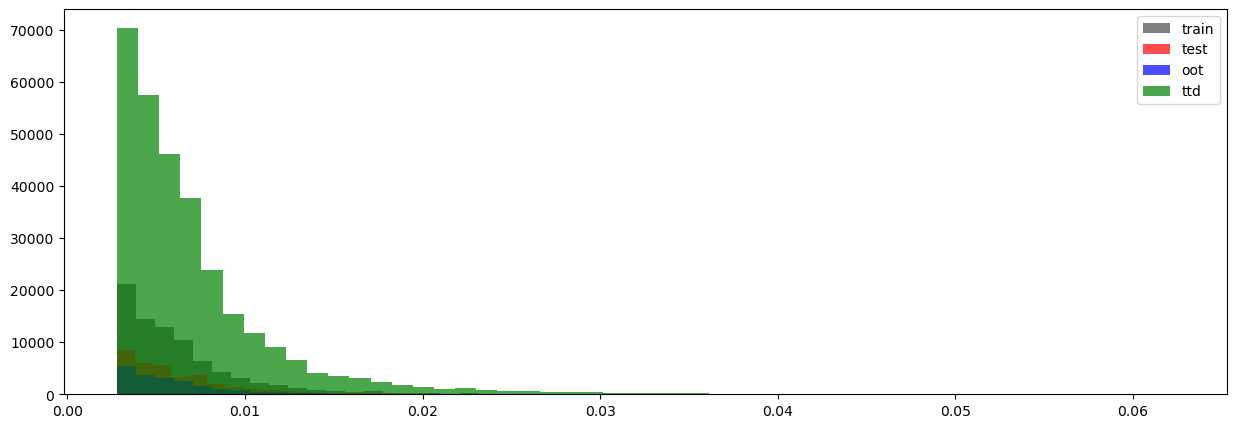

In [107]:
import matplotlib.pyplot as plt
plt.figure(figsize= (15, 5))
plt.hist(Train['p1'], bins= 50, label= 'train', color= 'black', alpha= 0.5)
plt.hist(Test['p1'], bins= 50, label= 'test', color= 'red', alpha= 0.7)
plt.hist(Oot['p1'], bins= 50, label= 'oot', color= 'blue', alpha= 0.7)
plt.hist(TTD['p1'], bins= 50, label= 'ttd', color= 'green', alpha= 0.7)
plt.legend()
plt.show()

In [108]:
Train['p1'].value_counts(dropna= False).head()

p1
0.006957    2494
0.003549    2402
0.003159    1946
0.005333    1725
0.003366    1607
Name: count, dtype: int64

In [110]:
df_bv= pd.DataFrame()

for col in col_list:
    print(col)
    ### Train
    temp_tr= Train.groupby(col).agg(
        bad_count_tr= ('bad_flag', 'sum'),
        bad_rate_tr= ('bad_flag', 'mean'),
                                p1_bad_rate_tr= ('p1', 'mean'),
                                   volume_tr= ('unique_id', 'count')).reset_index()
    temp_tr.columns= ['Bucket', 'Train_BadCount', 'Train_BadRate', 'Train_P1', 'Train_Count']
    temp_tr.insert(0, 'variable', col)
    
    # temp_tr= temp_tr.sort_values(by= ['bad_rate_tr']).reset_index(drop= True)
    # temp_tr['bad_rate_rank_tr']= range(1, len(temp_tr)+1)
    # temp_tr= temp_tr.sort_values(by= ['p1_bad_rate_tr']).reset_index(drop= True)
    # temp_tr['p1_bad_rank_tr']= range(1, len(temp_tr)+1)
    
    ### Test
    temp_te= Test.groupby(col).agg(
        bad_count_te= ('bad_flag', 'sum'),
        bad_rate_te= ('bad_flag', 'mean'),
                                p1_bad_rate_te= ('p1', 'mean'),
                                  volume_te= ('unique_id', 'count')).reset_index()
    temp_te.columns= ['Bucket', 'Test_BadCount', 'Test_BadRate', 'Test_P1', 'Test_Count']
    #temp_te['variable']= col
    
    # temp_te= temp_te.sort_values(by= ['bad_rate_te']).reset_index(drop= True)
    # temp_te['bad_rate_rank_te']= range(1, len(temp_te)+1)
    # temp_te= temp_te.sort_values(by= ['p1_bad_rate_te']).reset_index(drop= True)
    # temp_te['p1_bad_rank_te']= range(1, len(temp_te)+1)
    
    ### Concatenating
    temp= temp_tr.merge(temp_te, on= ['Bucket'], how= 'left')
    # temp= temp.sort_values(by= ['bucket']).reset_index(drop= True)
    temp= Bucket_Order(temp)
    # display(temp)
    
    df_bv= pd.concat([df_bv, temp]).reset_index(drop= True)
    
    del temp, temp_tr, temp_te

inquiryauto12month
inquiryshortterm12month
addrlastmovetaxratiodiff
sourcenonderogcount
addrcurrenttractratio
sourcenonderogcount03month
addrchangecount03month
inquirycollections12month
inquirynonshortterm12month
sourcenonderogcount12month
educationprogramattended
addrinputsubjectcount
assetpropevercount
addrchangecount60month
assetproppurchasetimeoldest
addrcurrentavmratio12monthprior
addrchangecount24month
addrinputdeedmailing
addrchangecount06month
assetpropnewestsaleprice
businessassociation
assetpropcurrentcount
addrchangecount12month
addrinputphoneservice
assetpropnewestmortgagetype
addrcurrentsubjectowned
addrcurrentdeedmailing
profliccount
addrcurrenttimenewest
assetpropsoldcount12month
addrcurrenttimelastsale
assetpropsalepurchaseratio
addrinputavmratio12monthprior
addrinputsubjectowned
educationattendance
subjectnewestrecord12month
addrinputproblems
assetpersonalcount
assetproppurchasecount12month
sourcenonderogcount06month
inquirytelcom12month


In [111]:
df_bv

,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,inquiryauto12month,[0],381.0,0.005024,0.005774,75840,156.0,0.004804,0.005772,32470.0,Yes
1,inquiryauto12month,[1],99.0,0.015986,0.014562,6193,49.0,0.018229,0.014557,2688.0,Yes
2,inquiryshortterm12month,[0],451.0,0.005547,0.006388,81304,194.0,0.005571,0.006386,34823.0,Yes
3,inquiryshortterm12month,[1],29.0,0.039781,0.011916,729,11.0,0.032836,0.012466,335.0,Yes
4,addrlastmovetaxratiodiff,[-1],314.0,0.004702,0.005636,66774,149.0,0.005203,0.005657,28636.0,NaN
5,addrlastmovetaxratiodiff,"[-inf, 0.375)",159.0,0.011431,0.010358,13910,54.0,0.009096,0.010305,5937.0,Yes
6,addrlastmovetaxratiodiff,"[0.375, inf)",7.0,0.005189,0.005677,1349,2.0,0.003419,0.005762,585.0,Yes
7,sourcenonderogcount,"[-inf, 3.0)",196.0,0.008732,0.008388,22446,93.0,0.009600,0.008411,9688.0,Yes
8,sourcenonderogcount,"[3.0, 4.0)",172.0,0.006239,0.006114,27569,67.0,0.005648,0.006125,11863.0,Yes
9,sourcenonderogcount,"[4.0, 5.0)",82.0,0.004513,0.005637,18170,31.0,0.004044,0.005593,7666.0,Yes


In [112]:
for client in Train['client'].unique():
    print(client)
    get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
                  data= Train[Train['client']== client], 
                  data_h2o= train_h2o[train_h2o['client']== client], 
                  target= 'bad_flag', 
                  cols_tuple= col_tuple_pass, 
                  score_col= 'p1', 
                  weight= 'conwt')
    

Numerica
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
9150 67.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.009126,0.052342,0.012967,1831,1799.0,32.0,1.75,20.01,19.81,47.76,27.95
1,0.006956,0.009126,0.007729,1829,1813.0,16.0,0.87,40.00,39.77,71.64,31.87
2,0.005333,0.006956,0.006103,1831,1820.0,11.0,0.60,60.01,59.80,88.06,28.26
3,0.004294,0.005333,0.004870,1830,1825.0,5.0,0.27,80.01,79.90,95.52,15.62
4,0.002785,0.004294,0.003606,1829,1826.0,3.0,0.16,100.00,100.00,100.00,0.00


{'Gini': 41.48, 'KS': 31.87}
Arkansas
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
18574 62.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.007165,0.054789,0.010867,3715,3680.0,35.0,0.94,20.0,19.88,56.45,36.57
1,0.005154,0.007165,0.006004,3715,3705.0,10.0,0.27,40.0,39.89,72.58,32.69
2,0.004024,0.005150,0.004621,3715,3708.0,7.0,0.19,60.0,59.92,83.87,23.95
3,0.003343,0.004024,0.003619,3715,3710.0,5.0,0.13,80.0,79.96,91.94,11.98
4,0.002785,0.003343,0.003044,3714,3709.0,5.0,0.13,100.0,100.00,100.00,0.00


{'Gini': 42.08, 'KS': 36.57}
SECU
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
6569 41.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.008628,0.049890,0.013205,1314,1295.0,19.0,1.45,20.00,19.84,46.34,26.50
1,0.006609,0.008624,0.007373,1314,1304.0,10.0,0.76,40.01,39.81,70.73,30.92
2,0.005073,0.006607,0.005738,1314,1308.0,6.0,0.46,60.01,59.85,85.37,25.52
3,0.003822,0.005059,0.004501,1314,1311.0,3.0,0.23,80.01,79.93,92.68,12.75
4,0.002785,0.003822,0.003397,1313,1310.0,3.0,0.23,100.00,100.00,100.00,0.00


{'Gini': 38.279999999999994, 'KS': 30.92}
GESA
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
8692 53.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.008632,0.053573,0.012927,1739,1711.0,28.0,1.61,20.01,19.81,52.83,33.02
1,0.006483,0.008632,0.007376,1738,1726.0,12.0,0.69,40.00,39.78,75.47,35.69
2,0.005030,0.006479,0.005726,1739,1729.0,10.0,0.58,60.01,59.80,94.34,34.54
3,0.004043,0.005029,0.004558,1738,1736.0,2.0,0.12,80.00,79.89,98.11,18.22
4,0.002785,0.004040,0.003456,1738,1737.0,1.0,0.06,100.00,100.00,100.00,0.00


{'Gini': 48.59, 'KS': 35.69}
Tower
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
19442 158.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.007922,0.056321,0.012263,3889,3805.0,84.0,2.16,20.0,19.73,53.16,33.43
1,0.006073,0.007922,0.006939,3888,3854.0,34.0,0.87,40.0,39.72,74.68,34.96
2,0.004748,0.006072,0.005298,3889,3871.0,18.0,0.46,60.0,59.79,86.08,26.29
3,0.003588,0.004748,0.004174,3888,3871.0,17.0,0.44,80.0,79.86,96.84,16.98
4,0.002785,0.003588,0.003287,3888,3883.0,5.0,0.13,100.0,100.00,100.00,0.00


{'Gini': 44.66, 'KS': 34.96}
CPM
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
4167 27.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.007939,0.044133,0.012482,834,820.0,14.0,1.68,20.01,19.81,51.85,32.04
1,0.005800,0.007936,0.006818,833,827.0,6.0,0.72,40.00,39.78,74.07,34.29
2,0.004690,0.005794,0.005191,834,832.0,2.0,0.24,60.02,59.88,81.48,21.60
3,0.003549,0.004690,0.004102,833,830.0,3.0,0.36,80.01,79.93,92.59,12.66
4,0.002785,0.003549,0.003239,833,831.0,2.0,0.24,100.00,100.00,100.00,0.00


{'Gini': 40.239999999999995, 'KS': 34.29}
Bethpage
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
4715 17.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.007095,0.044349,0.010755,944,942.0,2.0,0.21,20.02,20.05,11.76,8.29
1,0.005160,0.007095,0.005865,942,937.0,5.0,0.53,40.00,40.00,41.18,1.18
2,0.003844,0.005160,0.004549,944,939.0,5.0,0.53,60.02,59.98,70.59,10.61
3,0.003366,0.003844,0.003554,943,940.0,3.0,0.32,80.02,79.99,88.24,8.25
4,0.002785,0.003366,0.003121,942,940.0,2.0,0.21,100.00,100.00,100.00,0.00


{'Gini': 4.7, 'KS': 10.61}
Guardian
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
8790 38.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.009691,0.051030,0.014559,1759,1742.0,17.0,0.97,20.01,19.90,44.74,24.84
1,0.006957,0.009691,0.008066,1757,1746.0,11.0,0.63,40.00,39.85,73.68,33.83
2,0.005333,0.006957,0.006068,1759,1755.0,4.0,0.23,60.01,59.91,84.21,24.30
3,0.004011,0.005333,0.004706,1758,1752.0,6.0,0.34,80.01,79.92,100.00,20.08
4,0.002785,0.004011,0.003406,1757,1757.0,0.0,0.00,100.00,100.00,100.00,0.00


{'Gini': 41.22, 'KS': 33.83}
Hawaii
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
561 1.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.010942,0.042545,0.014191,113,113.0,0.0,0.00,20.14,20.18,0.0,20.18
1,0.008303,0.010869,0.009481,112,111.0,1.0,0.89,40.11,40.00,100.0,60.00
2,0.006819,0.008247,0.007441,112,112.0,0.0,0.00,60.07,60.00,100.0,40.00
3,0.005016,0.006724,0.005840,112,112.0,0.0,0.00,80.04,80.00,100.0,20.00
4,0.002785,0.004917,0.004075,112,112.0,0.0,0.00,100.00,100.00,100.0,0.00


{'Gini': 39.82, 'KS': 60.0}
HFCU
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
1068 14.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.007432,0.033658,0.011597,214,205.0,9.0,4.21,20.04,19.45,64.29,44.84
1,0.005333,0.007431,0.006116,214,212.0,2.0,0.93,40.07,39.56,78.57,39.01
2,0.003951,0.005333,0.004662,213,212.0,1.0,0.47,60.02,59.68,85.71,26.03
3,0.003366,0.003941,0.003592,214,213.0,1.0,0.47,80.06,79.89,92.86,12.97
4,0.002785,0.003366,0.003176,213,212.0,1.0,0.47,100.00,100.00,100.00,0.00


{'Gini': 49.16, 'KS': 44.84}
NCU
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
305 2.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.009333,0.039855,0.014854,62,62.0,0.0,0.00,20.33,20.46,0.0,20.46
1,0.006055,0.009150,0.007352,60,58.0,2.0,3.33,40.00,39.60,100.0,60.40
2,0.004823,0.006034,0.005376,62,62.0,0.0,0.00,60.33,60.07,100.0,39.93
3,0.003403,0.004816,0.004033,61,61.0,0.0,0.00,80.33,80.20,100.0,19.80
4,0.002785,0.003379,0.003165,60,60.0,0.0,0.00,100.00,100.00,100.0,0.00


{'Gini': 39.94, 'KS': 60.4}


### Basic Checks

In [113]:
TTD['funded_flag'].sum(), Train['funded_flag'].sum(), Test['funded_flag'].sum()

(111279.0, 82033.0, 35158.0)

In [114]:
TTD['id']= TTD['unique_id']+TTD['client']
Train['id']= Train['unique_id']+Train['client']
Test['id']= Test['unique_id']+Test['client']
Oot['id']= Oot['unique_id']+Oot['client']

In [118]:
TTD[TTD['id'].isin(Train[Train['client']!= 'CPM']['id'].unique())]['p1'].describe(), Train[Train['client']!= 'CPM']['p1'].describe()

(count    77866.000000
 mean         0.006441
 std          0.004015
 min          0.002785
 25%          0.003818
 50%          0.005333
 75%          0.007451
 max          0.056321
 Name: p1, dtype: float64,
 count    77866.000000
 mean         0.006441
 std          0.004015
 min          0.002785
 25%          0.003818
 50%          0.005333
 75%          0.007451
 max          0.056321
 Name: p1, dtype: float64)

In [119]:
import datetime

In [126]:
# Train[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_Train_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)
# Test[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_Test_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)
# Oot[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_Oot_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)
# TTD[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_TTD_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)

In [128]:
Train['fico_pb'].describe()

count    82004.000000
mean       754.249732
std         78.570496
min          0.000000
25%        710.000000
50%        762.000000
75%        807.000000
max        900.000000
Name: fico_pb, dtype: float64

In [129]:
TTD['fico_cut']= np.where(((TTD['fico_pb'].isnull()) |(TTD['fico_pb']<300)),"h.Missing",
                        np.where((TTD['fico_pb']>=300) &(TTD['fico_pb']<550),"a.300-550",
                                 np.where((TTD['fico_pb']>=550) &(TTD['fico_pb']<600),"a.550-600",
                                np.where((TTD['fico_pb']>=600) &(TTD['fico_pb']<630),"b.600-629",
                                    np.where((TTD['fico_pb']>=630) &(TTD['fico_pb']<660),"c.630-659",
                                        np.where((TTD['fico_pb']>=660) &(TTD['fico_pb']<690),"d.660-689",
                                            np.where((TTD['fico_pb']>=690) &(TTD['fico_pb']<715),"e.690-714",
                                                np.where((TTD['fico_pb']>=715) & (TTD['fico_pb']<740),"f.715-739",
                                                    np.where((TTD['fico_pb']>=740),"g.740+","h.Missing")))))))))

In [130]:
TTD.groupby('fico_cut').agg(
    ttd= ('unique_id', 'count'),
    approved= ('approve_flag', 'sum'),
    funded= ('funded_flag', 'sum'),
    bad= ('bad_flag', 'sum'),
    avg_pd= ('p1', 'mean')
)

,ttd,approved,funded,bad,avg_pd
fico_cut,,,,,
a.300-550,5131,419.0,278.0,8.0,0.011819
a.550-600,10428,2545.0,966.0,28.0,0.010830
b.600-629,14246,5982.0,1799.0,47.0,0.009914
c.630-659,24214,12605.0,4600.0,111.0,0.008981
d.660-689,34425,21499.0,9901.0,139.0,0.007963
e.690-714,33603,23664.0,11563.0,105.0,0.007268
f.715-739,33168,25159.0,12792.0,60.0,0.006788
g.740+,142643,123198.0,68966.0,131.0,0.005900
h.Missing,5162,877.0,414.0,19.0,0.008728


In [131]:
TTD.shape

(303020, 148)